# import things

In [94]:
# from pkg_resources import resource_filename
from pathlib import Path
import pandas as pd
import numpy as np
import nibabel as nb
from nibabel import cifti2 as ci
from contarg.normgrid import load_liston_surfs, Surface
# from contarg.stimgrid import run_opt_and_save_outputs
from contarg.utils import graph_from_triangles, get_stimroi_path, surf_data_from_cifti, load_timeseries, SurfROI, cross_spearman
# from contarg.utils import get_stimroi_path, get_refroi_path, graph_from_triangles, , new_cifti_like, surf_data_from_cifti, cross_spearman, load_timeseries, find_bids_files, add_censor_columns, select_confounds, make_rel_symlink
from scipy import stats
from scipy.spatial.distance import pdist, cdist
from statsmodels.stats import weightstats
from matplotlib import pyplot as plt
import seaborn as sns
import networkx as nx
from simnibs import opt_struct
from joblib import Parallel, delayed
import templateflow
import subprocess
from contarg.normgrid import get_prob_vine, setup_uncert_sims
# from contarg.utils import new_cifti_like
from contarg.stimgrid import angle_between

%matplotlib inline

# from sklearn.cluster import AgglomerativeClustering

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

In [2]:
maxMT=80
distancetoscalp=2
uncert_n = 1000
min_mt_thresh = 50
smoothing=5
subjects = ['24563', '24573', '24704', '24718', '24740', '24742', '24546']
pairwise_sig_thresh=0.1
outdir = Path('/data/EDB/TMSpilot/derivatives/contarg_liston')
liston_root = Path('/data/EDB/TMSpilot/liston')
stimroi="expandedcoleBA46"

acceptable_zangle = [(45,135), (225, 315)]

anat_dir = outdir / 'anat_preproc'
func_dir = outdir / 'func_preproc'

```
for each subject  
    load surfaces  
    load mean map  
    load std map
    load pos_list
    convert maps to Pct motor threshold  
    get set of above threshold vertices for each position  
    for each session  
        load time series  
        load functional clusters  
        (eventually, load personalized network assignments)  
        for each position  
            get connectivities
```          
        
        

# Find Comprehensive targets

In [3]:
pl_cols = [
                                                  'cx', 'cy', 'cz',
                                                  'nx', 'ny', 'nz', 
                                                  'bx', 'by', 'bz', 
                                                  'bxv', 'byv', 'bzv','z_angle',
                                                  's_idx', 's_x', 's_y', 's_z',
                                                 ]

In [4]:
stim_stats = []
min_mt = []
for subject in subjects:
    src_surf_dir = liston_root / f'sub-{subject}/anat/T1w/fsaverage_LR32k/'
    headmodel_dir = anat_dir /f'sub-{subject}/HeadModel'
    sim_out_dir = anat_dir / f'sub-{subject}/Simulation'
    sim_dir = sorted(sim_out_dir.glob('simulation-*'))[-1]

    uncert_dir = sim_dir / f'uncert{uncert_n}'
    if not uncert_dir.exists():
        raise FileNotFoundError(uncert_dir)

    # load surfaces
    surfaces = load_liston_surfs(subject, src_surf_dir)

    scalp_path = headmodel_dir / f'm2m_{subject}/Skin.surf.gii'
    scalp_points, scalp_triangles = nb.load(scalp_path).agg_data()
    scalp_G = graph_from_triangles(scalp_triangles)
    scalp = Surface(scalp_path, scalp_points, scalp_triangles, scalp_G, np.arange(len(scalp_points)).astype(int))

    stimroi_mask = get_stimroi_path(stimroi, cifti=True)
    stim_roi = SurfROI(surfaces.l.midthickness.path, 'left', roi=stimroi_mask)
    
    # load mean map
    magne_path = uncert_dir / f'sub-{subject}_space-fsLR_den-32k_desc-magnEmean_stat.dtseries.nii'
    magne_img = ci.load(magne_path)
    all_magne = magne_img.get_fdata()
    l_magne = surf_data_from_cifti(all_magne, magne_img.header.get_axis(1), 'CIFTI_STRUCTURE_CORTEX_LEFT')
    all_magne = all_magne.T
    l_mt = (l_magne / all_magne.max(0)) * maxMT
    l_percentile = np.argsort(np.argsort(l_magne, axis=None), axis=None).reshape(l_magne.shape)
    l_percentile = (l_percentile / (np.product(l_magne.shape) - 1)) * 100

    #load std map
    std_path = uncert_dir / f'sub-{subject}_space-fsLR_den-32k_desc-magnEstd_stat.dtseries.nii'
    std_img = ci.load(std_path)
    all_std = std_img.get_fdata()
    l_std = surf_data_from_cifti(all_std, std_img.header.get_axis(1), 'CIFTI_STRUCTURE_CORTEX_LEFT')
    all_std = all_std.T
    l_mt_std = (l_std / all_magne.max(0)) * maxMT
    
    #load prob map
    ap_path = uncert_dir / f'sub-{subject}_space-fsLR_den-32k_desc-abovethreshactprobs_stat.dtseries.nii'
    ap_img = ci.load(ap_path)
    all_ap = ap_img.get_fdata()
    l_ap = surf_data_from_cifti(all_ap, ap_img.header.get_axis(1), 'CIFTI_STRUCTURE_CORTEX_LEFT')
    all_ap = all_ap.T

    # load va map
    va_path = src_surf_dir / f'sub-{subject}.midthickness_va.32k_fs_LR.dscalar.nii'
    va_img = ci.load(va_path)
    all_va = va_img.get_fdata()
    l_va = surf_data_from_cifti(all_va, va_img.header.get_axis(1), 'CIFTI_STRUCTURE_CORTEX_LEFT')
    
    # find vals significantly above minimum
    zvals = np.zeros(l_mt.shape)
    zvals[l_mt != 0] = (l_mt[l_mt != 0] - min_mt_thresh) / l_mt_std[l_mt != 0]
    # zdist = stats.norm()
    # pvals = zdist.sf(zvals)
    # sigs = pvals < 0.5
    sigs = l_ap > 0

    zvals = zvals.T
    sigs = sigs.T
    
    pos_list = pd.read_pickle(sim_dir / f'sub-{subject}_simulations.pkl.gz')
    
    # find ids for everything significantly above minimum
    pos_iidxs = []
    for (pos_ix, zval, sig) in zip(pos_list.pos_ix.values, zvals, sigs):
        pos_mt = l_mt[:, pos_ix]
        pos_mt_std = l_mt_std[:, pos_ix]
        pos_ap = l_ap[:, pos_ix]
       
        vert = sig.nonzero()[0]

        rows = [dict(idx=ivert,
                 pos_ix=pos_ix,
                 actprob=iap,
                 magne=imagne,
                 std=istd,
                 percentile=ipct,
                 motor_threshold=imt,
                 motor_threshold_std=imtstd,
                 mt_zval=izval,
                 vertex_area=iva
                 )
            for ivert, iap, imagne,istd, ipct, imt, imtstd, izval, iva
            in zip(
            vert,
            pos_ap[vert],
            l_magne[vert, pos_ix],
            l_std[vert, pos_ix],
            l_percentile[vert, pos_ix],
            pos_mt[vert],
            pos_mt_std[vert],
            zval[vert],
            l_va[vert, 0]
        )]
        pos_iidxs.extend(rows)
    pos_iidxs = pd.DataFrame(pos_iidxs)
    pos_iidxs['in_stim'] = pos_iidxs.idx.isin(stim_roi.idxs)
    minmt_row = dict(
        subject=subject,
        min_mt=pos_iidxs.motor_threshold.min()
    )
    min_mt.append(minmt_row)
    t = min_mt_thresh
    m = -0.9 / (t - 80)
    b = 1 - (m * 80)
    80 * m + b
    pos_iidxs['mt_weight'] = pos_iidxs.motor_threshold * m + b
    pos_iidxs['weighted_in_stim'] = pos_iidxs.in_stim * pos_iidxs.actprob
    iidxs = pos_iidxs.loc[:, ['idx']].drop_duplicates().reset_index(drop=True)

    for session in [1,2]:
        for smoothing in [2.55]:
            # load functional data
            lrest_dir = liston_root / f'sub-{subject}/func/rest'
            concat_nii = lrest_dir / f'session_{session}/concatenated/Rest_session-{session}_OCME+MEICA+MGTR_Concatenated+SubcortRegression+SpatialSmoothing{smoothing}.dtseries.nii'
            timeseries = [concat_nii]
            lts_data, rts_data, ts_data = load_timeseries(timeseries)

            # load clusters
            clust_dir = func_dir / f'sub-{subject}/ses-{session}/cluster'
            dstim_clusters = pd.read_pickle(clust_dir / f'sub-{subject}_ses-{session}_smoothing-{smoothing}_dstimclusters.pkl.gz')
            dstim_verts = pd.read_pickle(clust_dir / f'sub-{subject}_ses-{session}_smoothing-{smoothing}_dstimverts.pkl.gz')
            ref_clusters = pd.read_pickle(clust_dir / f'sub-{subject}_ses-{session}_smoothing-{smoothing}_refclusters.pkl.gz')
            ref_repts = np.load(clust_dir / f'sub-{subject}_ses-{session}_smoothing-{smoothing}_refrepts.npz.npy')
            ref_ts = np.load(clust_dir / f'sub-{subject}_ses-{session}_smoothing-{smoothing}_refts.npz.npy')


            # get vertex wise correlations for intensity eval
            vert_rep_corr, _, _ = cross_spearman(lts_data[iidxs.idx.values], np.array(list(ref_clusters.repts.values)),
                                                                  alpha=pairwise_sig_thresh, method='fdr_bh')
            vert_rep_zs = np.arctanh(vert_rep_corr)
            vert_rep_ds = weightstats.DescrStatsW(vert_rep_zs.T, weights=ref_clusters.nvert.values)
            vert_rep_mean = np.tanh(vert_rep_ds.mean)
            vert_rep_t, vert_rep_p = vert_rep_ds.ztest_mean()
            iidxs['vert_rep_mean'] = vert_rep_mean
            iidxs['vert_rep_avet'] = vert_rep_t
            iidxs['vert_rep_avep'] = vert_rep_p

            n = ref_repts.shape[1]
            rs = vert_rep_mean
            ts = rs * np.sqrt((n - 2) / ((rs + 1.0) * (1.0 - rs)))
            iidxs['vert_rep_rp'] = stats.t.sf(np.abs(ts), n - 2) * 2

            # get cluster stats
            iidxs_tsc = iidxs.merge(dstim_verts, how='left', on='idx')

            pos_iidxs_tsc = pos_iidxs.merge(iidxs_tsc, how='left', on='idx')
            for pos_ix, df in pos_iidxs_tsc.groupby('pos_ix'):
                rep_zs = np.arctanh(df.vert_rep_mean)
                weights = df['actprob'].values
                if weights.sum() < 1:
                    continue

                rep_ds = weightstats.DescrStatsW(rep_zs.T, weights=weights)
                rep_mean = np.tanh(rep_ds.mean)
                rep_std = np.tanh(rep_ds.std)
                rep_t, _ = rep_ds.ztest_mean()
                if rep_std == 0:
                    continue
                rep_va_ds = weightstats.DescrStatsW(rep_zs.T, weights=weights * df.vertex_area.values)
                rep_va_mean = np.tanh(rep_va_ds.mean)

                rep_neg = rep_zs < 0
                rn_ds = weightstats.DescrStatsW(rep_neg.T, weights=weights) 
                in_stim_ds = weightstats.DescrStatsW(df.in_stim.values, weights=weights)
                rn_va_ds = weightstats.DescrStatsW(rep_neg.T , weights=weights * df.vertex_area) 
                in_stim_va_ds = weightstats.DescrStatsW(df.in_stim.values , weights=weights * df.vertex_area)
                mt_ds = weightstats.DescrStatsW(df.motor_threshold.values, weights=weights)
                row = dict(
                    subject=subject,
                    session=session,
                    smoothing=smoothing,
                    pos_ix=pos_ix,
                    n = len(df),
                    weighted_n = weights.sum(),
                    area = df.vertex_area.sum(),
                    weighted_area =  (df.vertex_area * weights).sum(),
                    prop_neg=rn_ds.mean,
                    prop_va_neg=rn_va_ds.mean,
                    rep_mean=rep_mean,
                    rep_va_mean = rep_va_mean,
                    rep_std=rep_std,
                    rep_t=rep_t,
                    in_stim=in_stim_ds.mean,
                    in_stim_va=in_stim_va_ds.mean,
                    mt=mt_ds.mean,
                    mt_std=mt_ds.std,
                )
                row.update(pos_list.loc[pos_list.pos_ix == pos_ix, pl_cols].iloc[0].to_dict())
                stim_stats.append(row)
stim_stats_rev = pd.DataFrame(stim_stats)

stim_stats_rev['rep_r_rank'] = (
    stim_stats_rev
    .sort_values(['in_stim'], ascending=False)
    .groupby(['subject', 'session', 'smoothing',])
    .rep_mean
    .transform('rank', method='first', ascending=True)
)
stim_stats_rev['rep_rva_rank'] = (
    stim_stats_rev
    .sort_values(['in_stim'], ascending=False)
    .groupby(['subject', 'session', 'smoothing',])
    .rep_va_mean
    .transform('rank', method='first', ascending=True)
)


In [5]:
ses_comp_cols = [
    'subject',
    'smoothing',
    'pos_ix',
    'weighted_n',
    'area',
    'weighted_area',
    'rep_r_rank',
    'rep_rva_rank',
    'rep_mean',
    'rep_va_mean',
    'rep_std',
    'rep_t',
    'prop_neg',
    'prop_va_neg',
    'in_stim',
    'in_stim_va',
    'bx',
    'by',
    'bz',
    's_x',
    's_y',
    's_z',
    'z_angle'
]

In [6]:
ss1 = stim_stats_rev.loc[stim_stats_rev.session == 1, ses_comp_cols]
ss2 = stim_stats_rev.loc[stim_stats_rev.session == 2, ses_comp_cols]
ssw = ss1.merge(ss2, how='inner', on=['subject', 'smoothing', 'pos_ix',], suffixes=['_1', '_2'])


In [7]:
check_cols = ['subject', 'smoothing', 'pos_ix',
              'rep_r_rank_1', 'rep_r_rank_2',
              'rep_rva_rank_1', 'rep_rva_rank_2',
              'rep_mean_1', 'rep_mean_2',
              'rep_va_mean_1', 'rep_va_mean_2',
              'weighted_n_1', 'weighted_n_2',
              'prop_neg_1', 'prop_neg_2',
              'prop_va_neg_1', 'prop_va_neg_2',
              'z_angle_1'
             ]
ssw.query("rep_rva_rank_1 == 1 | rep_rva_rank_2 == 1").sort_values(['subject', 'smoothing']).loc[:, check_cols]

,subject,smoothing,pos_ix,rep_r_rank_1,rep_r_rank_2,rep_rva_rank_1,rep_rva_rank_2,rep_mean_1,rep_mean_2,rep_va_mean_1,rep_va_mean_2,weighted_n_1,weighted_n_2,prop_neg_1,prop_neg_2,prop_va_neg_1,prop_va_neg_2,z_angle_1
834,24546,2.55,49,1.0,1.0,1.0,1.0,-0.153627,-0.099110,-0.150259,-0.096443,90.264609,90.264609,0.813048,0.826254,0.809706,0.816855,341.347198
6,24563,2.55,6,9.0,1.0,7.0,1.0,-0.026205,-0.028267,-0.026295,-0.028103,143.554607,143.554607,0.685949,0.636830,0.685431,0.628295,55.665885
110,24563,2.55,110,1.0,28.0,1.0,44.0,-0.030118,-0.012977,-0.029036,-0.011500,79.351057,79.351057,0.750139,0.523227,0.739029,0.505798,13.141882
137,24573,2.55,1,1.0,2.0,1.0,1.0,-0.086049,-0.074195,-0.086039,-0.075414,105.767901,105.767901,0.840613,0.789658,0.847446,0.793742,171.833490
311,24704,2.55,56,5.0,1.0,5.0,1.0,-0.000430,-0.012813,0.004571,-0.003350,182.039188,182.039188,0.520723,0.505219,0.488203,0.479083,271.655977
313,24704,2.55,58,1.0,3.0,1.0,3.0,-0.007824,-0.009493,-0.002284,-0.000029,176.749444,176.749444,0.569165,0.485013,0.535344,0.457038,82.234834
401,24718,2.55,33,2.0,1.0,2.0,1.0,-0.155749,-0.122443,-0.156866,-0.123119,69.099306,69.099306,0.955837,0.971559,0.949912,0.968991,175.962639
443,24718,2.55,75,1.0,7.0,1.0,6.0,-0.155920,-0.117319,-0.159410,-0.119019,68.100153,68.100153,0.967353,0.975262,0.971696,0.978046,147.830744
532,24740,2.55,33,1.0,1.0,1.0,1.0,-0.119020,-0.119953,-0.123068,-0.125068,62.662353,62.662353,0.863793,0.740800,0.872037,0.751627,291.505734
662,24742,2.55,38,1.0,1.0,1.0,1.0,-0.184116,-0.169984,-0.181546,-0.167757,104.660188,104.660188,0.858563,0.851131,0.862316,0.854587,115.600904


# Find Restricted targets

In [8]:
vert_thresh = 0


In [9]:
def make_va_sort_func(va):
    return lambda x: va[np.array(list(x)).astype(int)].sum()

In [10]:
all_scores = []
bgsva_peaks = []
for subject in subjects:

    src_surf_dir = liston_root / f'sub-{subject}/anat/T1w/fsaverage_LR32k/'
    headmodel_dir = anat_dir /f'sub-{subject}/HeadModel'
    sim_out_dir = anat_dir / f'sub-{subject}/Simulation'
    sim_dir = sorted(sim_out_dir.glob('simulation-*'))[-1]
    uncert_dir = sim_dir / f'uncert{uncert_n}'
    if not uncert_dir.exists():
        raise FileNotFoundError(uncert_dir)

    # load surfaces
    surfaces = load_liston_surfs(subject, src_surf_dir)

    scalp_path = headmodel_dir / f'm2m_{subject}/Skin.surf.gii'
    scalp_points, scalp_triangles = nb.load(scalp_path).agg_data()
    scalp_G = graph_from_triangles(scalp_triangles)
    scalp = Surface(scalp_path, scalp_points, scalp_triangles, scalp_G, np.arange(len(scalp_points)).astype(int))

    stimroi_mask = get_stimroi_path(stimroi, cifti=True)
    stim_roi = SurfROI(surfaces.l.midthickness.path, 'left', roi=stimroi_mask)

    sulc_nii = src_surf_dir.parent.parent/f'MNINonLinear/fsaverage_LR32k/sub-{subject}.sulc.32k_fs_LR.dscalar.nii'
    sulc = nb.load(sulc_nii)
    sulc_dat = sulc.get_fdata()
    l_sulc = surf_data_from_cifti(sulc_dat, sulc.header.get_axis(1), 'CIFTI_STRUCTURE_CORTEX_LEFT').squeeze()
    
    # load va map
    va_path = src_surf_dir / f'sub-{subject}.midthickness_va.32k_fs_LR.dscalar.nii'
    va_img = ci.load(va_path)
    all_va = va_img.get_fdata()
    l_va = surf_data_from_cifti(all_va, va_img.header.get_axis(1), 'CIFTI_STRUCTURE_CORTEX_LEFT')

    pos_list = pd.read_pickle(sim_dir / f'sub-{subject}_simulations.pkl.gz')

    for session in [1,2]:
        for smoothing in [2.55]:
            # load functional data
            lrest_dir = liston_root / f'sub-{subject}/func/rest'
            concat_nii = lrest_dir / f'session_{session}/concatenated/Rest_session-{session}_OCME+MEICA+MGTR_Concatenated+SubcortRegression+SpatialSmoothing{smoothing}.dtseries.nii'
            timeseries = [concat_nii]
            lts_data, rts_data, ts_data = load_timeseries(timeseries)

            # load clusters
            clust_dir = func_dir / f'sub-{subject}/ses-{session}/cluster'
            dstim_clusters = pd.read_pickle(clust_dir / f'sub-{subject}_ses-{session}_smoothing-{smoothing}_dstimclusters.pkl.gz')
            dstim_verts = pd.read_pickle(clust_dir / f'sub-{subject}_ses-{session}_smoothing-{smoothing}_dstimverts.pkl.gz')
            ref_clusters = pd.read_pickle(clust_dir / f'sub-{subject}_ses-{session}_smoothing-{smoothing}_refclusters.pkl.gz')
            ref_repts = np.load(clust_dir / f'sub-{subject}_ses-{session}_smoothing-{smoothing}_refrepts.npz.npy')
            ref_ts = np.load(clust_dir / f'sub-{subject}_ses-{session}_smoothing-{smoothing}_refts.npz.npy')


            # get vertex wise correlations for intensity eval
            vert_rep_corr, _, _ = cross_spearman(lts_data[stim_roi.idxs], np.array(list(ref_clusters.repts.values)),
                                                                  alpha=pairwise_sig_thresh, method='fdr_bh')
            vert_rep_zs = np.arctanh(vert_rep_corr)
            vert_rep_ds = weightstats.DescrStatsW(vert_rep_zs.T, weights=ref_clusters.nvert.values)
            vert_rep_mean = np.tanh(vert_rep_ds.mean)
            
            vert_rep_t, vert_rep_p = vert_rep_ds.ztest_mean()
            # iidxs['vert_rep_mean'] = vert_rep_mean
            # iidxs['vert_rep_avet'] = vert_rep_t
            # iidxs['vert_rep_avep'] = vert_rep_p
            

            neg_G = stim_roi._G.subgraph(stim_roi.idxs[vert_rep_mean < vert_thresh]).copy()
            comp_info = []
            for ccid, cc in enumerate(sorted(nx.connected_components(neg_G), key=make_va_sort_func(l_va), reverse=True)):
                cc = np.array(list(cc))
                gyral_nodes = cc[l_sulc[cc] > 0]
                gyral_G = neg_G.subgraph(gyral_nodes).copy()
                if len(gyral_G) > 0:
                    biggest_gyral_subset = max(nx.connected_components(gyral_G), key=make_va_sort_func(l_va))        
                    #pos_iidxs['in_bgs'] = pos_iidxs.idx.isin(biggest_gyral_subset)
                    if ccid == 0:
                        # find the peak gyral value that's not on the edge of cluster
                        # we'll get an optimal simnibs target for this
                        bgs_vert_rep_means = vert_rep_mean[np.array([sri in biggest_gyral_subset for sri in stim_roi.idxs])]
                        bgs_peak_idxs = np.array(list(biggest_gyral_subset))[np.argsort(bgs_vert_rep_means)]
                        bgs_vert_rep_means = sorted(bgs_vert_rep_means)
                        surrounded_peak_found = False
                        for bgs_idx, bgs_vrm in zip(bgs_peak_idxs, bgs_vert_rep_means):
                            surrounded = (vert_rep_mean[np.array([sri in list(stim_roi._G.neighbors(bgs_idx))for sri in stim_roi.idxs])] < vert_thresh).all()
                            if surrounded:
                                surrounded_peak_found = True
                                coord = stim_roi.coords[stim_roi.idxs == bgs_idx][0]
                                row=dict(
                                    subject=subject,
                                    session=session,
                                    smoothing=smoothing,
                                    surrounded=True,
                                    x=coord[0],
                                    y=coord[1],
                                    z=coord[2],
                                    clust_size=len(cc),
                                    clust_area=l_va[np.array(list(cc)).astype(int)].sum(),
                                    peak_val=bgs_vrm,
                                    peak_idx=bgs_idx,
                                )
                                break
                        # If none of the gyral points are surrounded, just take the biggest
                        if not surrounded_peak_found:
                            coord = stim_roi.coords[stim_roi.idxs == bgs_peak_idxs[0]][0]
                            row=dict(
                                subject=subject,
                                session=session,
                                smoothing=smoothing,
                                surounded=False,
                                x=coord[0],
                                y=coord[1],
                                z=coord[2],
                                clust_size=len(cc),
                                clust_area=l_va[np.array(list(cc)).astype(int)].sum(),
                                peak_val=bgs_vrm,
                                peak_idx=bgs_idx,
                            )
                        bgsva_peaks.append(row)
                else:
                    continue

                
bgsva_peaks = pd.DataFrame(bgsva_peaks)
        

In [11]:
bgsva_peaks.sort_values(['subject', 'session'])

,subject,session,smoothing,surrounded,x,y,z,clust_size,clust_area,peak_val,peak_idx
12,24546,1,2.55,True,-42.793949,32.562183,1.802103,449,1528.671366,-0.426592,11680
13,24546,2,2.55,True,-43.705750,29.623264,17.478905,430,1456.145457,-0.172753,18491
0,24563,1,2.55,True,-49.700371,33.902435,4.797913,197,778.371342,-0.092104,11628
1,24563,2,2.55,True,-31.756489,50.297459,9.358648,442,1668.665725,-0.170577,27869
2,24573,1,2.55,True,-49.588867,28.180380,10.502846,449,1529.054625,-0.249221,18782
3,24573,2,2.55,True,-45.195621,36.951939,20.256920,377,1297.729352,-0.231708,30093
4,24704,1,2.55,True,-45.104385,21.694630,15.982930,71,204.576727,-0.097635,18819
5,24704,2,2.55,True,-41.287853,34.670872,14.712914,380,1241.553549,-0.268823,18831
6,24718,1,2.55,True,-47.630409,28.733618,16.150019,431,1601.702150,-0.230965,18871
7,24718,2,2.55,True,-47.982395,31.667059,13.200858,489,1783.647283,-0.166929,18829


## Run optimizations to find stimulator locations for cortical targets 

In [12]:
bgs_peaks = bgsva_peaks

In [31]:
bgs_peaks = bgs_peaks.sort_values(['subject', 'x', 'y', 'z'])
bgs_peaks.sort_values(['subject', 'smoothing', 'session'])
bgs_peaks['dup'] = bgs_peaks.loc[:, ['subject', 'x', 'y', 'z']].duplicated()
bgs_peaks['peak_ix'] = range(len(bgs_peaks))

In [25]:
jobs = []
opt_dirs = []
for subject, df in bgs_peaks.groupby('subject'):
    headmodel_dir = anat_dir /f'sub-{subject}/HeadModel'
    sim_out_dir = anat_dir / f'sub-{subject}/Simulation'

    coil='MagVenture_MCF-B65.ccd'
    try:
        m2m_dir = sorted(headmodel_dir.glob('m2m*'))[0]
    except IndexError:
        raise FileNotFoundError(f"No m2m directory found in {headmodel_dir}")
    skinsurf_path = m2m_dir / 'Skin.surf.gii'
    subject = '_'.join(m2m_dir.parts[-1].split('_')[1:])
    headmesh_path = m2m_dir / f'{subject}.msh'

    if not Path(coil).exists():
        simnibs_coil_dir = Path(resource_filename('simnibs', 'resources/coil_models'))
        coil_path = simnibs_coil_dir / f'Drakaki_BrainStim_2022/{coil}'
        if not coil_path.exists():
            coil_path = simnibs_coil_dir / f'legacy_and_other/{coil}'
            if not coil_path.exists():
                raise FileNotFoundError(f"Could not find coil ({coil}) in {simnibs_coil_dir}.")
    else:
        coil_path = Path(coil)
    sim_run_n = 0
    sim_dir =  sim_out_dir / f'alternate_targeting-00'

    #sim_dir =  sim_out_dir / f'alternate_targeting-{sim_run_n:02d}'
    # while sim_dir.exists():
    #     sim_run_n += 1
    #     sim_dir =  sim_out_dir / f'alternate_targeting-{sim_run_n:02d}'
    
    sim_dir.mkdir(exist_ok=True)
    for ix, row in df.iterrows():
        # run opt if it's not a duplicate
        if not row.dup:
            poso_outdir = sim_dir / f'opt-{row.peak_ix:04d}'
            
            assert poso_outdir.parent.exists()
            if poso_outdir.exists():
                raise ValueError(f"Output directory {poso_outdir} exists, Simnibs won't run.")
            o = opt_struct.TMSoptimize()
            o.fnamehead = headmesh_path.as_posix()
            o.pathfem = poso_outdir.as_posix()
            o.fnamecoil = coil_path.as_posix()
            o.target = np.array([row.x, row.y, row.z])
            o.target_size = 2
            o.distance = distancetoscalp
            o.method='ADM'
            # o.map_to_vol = True
            # o.map_to_surf = True
            # o.fields = 'eE'
            o.angle_resolution = 5
            o.spatial_resolution = 2
            o.solver_options='paradiso'
            o.open_in_gmsh=False
            jobs.append(delayed(run_opt_and_save_outputs)(o))
        opt_dirs.append(poso_outdir)

In [26]:
print(len(jobs), flush=True)
Parallel(n_jobs=20, verbose=10)(jobs)

36


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[ simnibs ]INFO: Running simulations in the directory: /data/EDB/TMSpilot/derivatives/contarg_liston/anat_preproc/sub-245461/Simulation/alternate_targeting-00/opt-0007
[ simnibs ]INFO: Head Mesh: /data/EDB/TMSpilot/derivatives/contarg_liston/anat_preproc/sub-245461/HeadModel/m2m_245461/245461.msh
[ simnibs ]INFO: Subject Path: /data/EDB/TMSpilot/derivatives/contarg_liston/anat_preproc/sub-245461/HeadModel/m2m_245461
[ simnibs ]INFO: Simulation Folder: /data/EDB/TMSpilot/derivatives/contarg_liston/anat_preproc/sub-245461/Simulation/alternate_targeting-00/opt-0007
[ simnibs ]INFO: Running simulations in the directory: /data/EDB/TMSpilot/derivatives/contarg_liston/anat_preproc/sub-245461/Simulation/alternate_targeting-00/opt-0005
[ simnibs ]INFO: Head Mesh: /data/EDB/TMSpilot/derivatives/contarg_liston/anat_preproc/sub-245461/HeadModel/m2m_245461/245461.msh
[ simnibs ]INFO: Subject Path: /data/EDB/TMSpilot/deriva

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [27]:
bgs_peaks['out_dir'] = opt_dirs

In [28]:
bgs_peaks.to_pickle('bgs_peaks.pkl.gz')

In [21]:
bgs_peaks = pd.read_pickle('bgs_peaks.pkl.gz')


### Convert outputs to surfaces

In [34]:
coil_name = coil.split('.')[0]
outstats = []
for ix, row in bgs_peaks.iterrows():
    subject = row.subject
    vol_outdir = row.out_dir / 'subject_volumes'
    target_path = vol_outdir / f'{subject}_TMS_1-0001_{coil_name}_Target.nii.gz'
    magn_path = vol_outdir / f'{subject}_TMS_1-0001_{coil_name}_magnE.nii.gz'
    norm_path = vol_outdir / f'{subject}_TMS_1-0001_{coil_name}_E.nii.gz'
    optmat_path = row.out_dir / f'{subject}_TMS_optimize_{coil_name}_optmat.npy'
    irow = dict(
        target_path=target_path,
        target_path_exist=target_path.exists(),
        magn_path=magn_path,
        magn_path_exist=magn_path.exists(),
        norm_path=norm_path,
        norm_path_exist=norm_path.exists(),
        optmat_path=optmat_path,
        optmat_path_exist=optmat_path.exists()
    )
    if optmat_path.exists():
            optmat = np.load(optmat_path)
            irow['bx'] = optmat[0,3]
            irow['by'] = optmat[1,3]
            irow['bz'] = optmat[2,3]
            irow['bxv'] = optmat[:-1, 0]
            irow['byv'] = optmat[:-1, 1]
            irow['bzv'] = optmat[:-1, 2]
    outstats.append(irow)
outstats = pd.DataFrame(outstats)
bgs_peak_stats = pd.concat([bgs_peaks.reset_index(drop=True), outstats], axis=1)

In [31]:
medial_wall = {}
medial_wall['l'] = templateflow.api.get(template='fsLR', density='32k', desc='nomedialwall', hemi='L')
medial_wall['r'] = templateflow.api.get(template='fsLR', density='32k', desc='nomedialwall', hemi='R')


In [32]:
for subject, df in bgs_peak_stats.groupby('subject'):
    src_surf_dir = liston_root / f'sub-{subject}/anat/T1w/fsaverage_LR32k/'
    surfaces = load_liston_surfs(subject,src_surf_dir)
    sim_dir = df.iloc[0].out_dir.parent
    # concat magnE
    catted = sim_dir / f"sub-{subject}_desc-magnE_stat.nii.gz"
    if not catted.exists():
        cmd = [
            "3dTcat",
            "-overwrite",
            "-prefix",
            catted,
            f"{sim_dir.as_posix()}/opt-*/subject_volumes/*_magnE.nii.gz"
        ]
        subprocess.run(cmd, check=True)
    # concat target
    catted = sim_dir / f"sub-{subject}_desc-target_stat.nii.gz"
    if not catted.exists():
        cmd = [
            "3dTcat",
            "-DAFNI_GLOB_SELECTORS=YES",
            "-overwrite",
            "-prefix",
            catted,
            f"{sim_dir.as_posix()}/opt-*/subject_volumes/*_Target.nii.gz[0]"
        ]
        subprocess.run(cmd, check=True)
    # concat evec
    catted = sim_dir / f"sub-{subject}_desc-Ei_stat.nii.gz"
    if not catted.exists():
        cmd = [
            "3dTcat",
            "-DAFNI_GLOB_SELECTORS=YES",
            "-overwrite",
            "-prefix",
            catted,
            f"{sim_dir.as_posix()}/opt-*/subject_volumes/*_E.nii.gz[0]"
        ]
        subprocess.run(cmd, check=True)

    catted = sim_dir / f"sub-{subject}_desc-Ej_stat.nii.gz"
    if not catted.exists():
        cmd = [
            "3dTcat",
            "-DAFNI_GLOB_SELECTORS=YES",
            "-overwrite",
            "-prefix",
            catted,
            f"{sim_dir.as_posix()}/opt-*/subject_volumes/*_E.nii.gz[1]"
        ]
        subprocess.run(cmd, check=True)

    catted = sim_dir / f"sub-{subject}_desc-Ek_stat.nii.gz"
    if not catted.exists():
        cmd = [
            "3dTcat",
            "-DAFNI_GLOB_SELECTORS=YES",
            "-overwrite",
            "-prefix",
            catted,
            f"{sim_dir.as_posix()}/opt-*/subject_volumes/*_E.nii.gz[2]"
        ]
        subprocess.run(cmd, check=True)

    consolidated_paths = [sim_dir / f"sub-{subject}_desc-{metric}_stat.nii.gz" for metric in ['magnE', 'Ei', 'Ej', 'Ek', 'target']]
    for metric_path in consolidated_paths:
        cifti_out = metric_path.as_posix().replace(".nii.gz", ".dtseries.nii").replace("_desc-", "_space-fsLR_den-32k_desc-")
        if not Path(cifti_out).exists():
            l_out_gifti = metric_path.as_posix().replace(".nii.gz", ".shape.gii").replace("_desc-", "_hemi-L_space-fsLR_den-32k_desc-")
            l_v2s_cmd = [
                'wb_command',
                '-volume-to-surface-mapping',
                metric_path.as_posix(),
                surfaces.l.midthickness.path,
                l_out_gifti,
                '-ribbon-constrained',
                surfaces.l.white.path,
                surfaces.l.pial.path,
            ]
            subprocess.run(l_v2s_cmd, check=True)

            l_metricmask_cmd = [
                'wb_command',
                '-metric-mask',
                l_out_gifti,
                medial_wall['l'],
                l_out_gifti
            ]
            subprocess.run(l_metricmask_cmd, check=True)


            r_out_gifti = metric_path.as_posix().replace(".nii.gz", ".shape.gii").replace("_desc-", "_hemi-R_space-fsLR_den-32k_desc-")
            r_v2s_cmd = [
                'wb_command',
                '-volume-to-surface-mapping',
                metric_path.as_posix(),
                surfaces.r.midthickness.path,
                r_out_gifti,
                '-ribbon-constrained',
                surfaces.r.white.path,
                surfaces.r.pial.path,
            ]
            subprocess.run(r_v2s_cmd, check=True)

            r_metricmask_cmd = [
                'wb_command',
                '-metric-mask',
                r_out_gifti,
                medial_wall['r'],
                r_out_gifti
            ]
            subprocess.run(r_metricmask_cmd, check=True)

            create_cifti_cmd = [
                'wb_command',
                '-cifti-create-dense-timeseries',
                cifti_out,
                '-left-metric',
                l_out_gifti,
                '-roi-left',
                medial_wall['l'],
                '-right-metric',
                r_out_gifti,
                '-roi-right',
                medial_wall['r'],
            ]
            subprocess.run(create_cifti_cmd, check=True)

++ 3dTcat: AFNI version=AFNI_23.3.09 (Nov 22 2023) [64-bit]
++ WARNING: file /home/nielsond/.afni.log is now 866028582 (866 million) bytes long!
*+ WARNING: Set TR of output dataset to 1.0 s
++ elapsed time = 2.6 s
++ 3dTcat: AFNI version=AFNI_23.3.09 (Nov 22 2023) [64-bit]
++ WARNING: file /home/nielsond/.afni.log is now 866028902 (866 million) bytes long!
*+ WARNING: Set TR of output dataset to 1.0 s
++ elapsed time = 1.8 s
++ 3dTcat: AFNI version=AFNI_23.3.09 (Nov 22 2023) [64-bit]
++ WARNING: file /home/nielsond/.afni.log is now 866029227 (866 million) bytes long!
++ elapsed time = 3.9 s
++ 3dTcat: AFNI version=AFNI_23.3.09 (Nov 22 2023) [64-bit]
++ WARNING: file /home/nielsond/.afni.log is now 866029543 (866 million) bytes long!
++ elapsed time = 3.9 s
++ 3dTcat: AFNI version=AFNI_23.3.09 (Nov 22 2023) [64-bit]
++ WARNING: file /home/nielsond/.afni.log is now 866029859 (866 million) bytes long!
++ elapsed time = 3.9 s
++ 3dTcat: AFNI version=AFNI_23.3.09 (Nov 22 2023) [64-bit]
++ 

In [30]:
bgs_peak_stats

,subject,session,smoothing,surrounded,x,y,z,clust_size,clust_area,peak_val,peak_idx,dup,peak_ix,out_dir,target_path,target_path_exist,magn_path,magn_path_exist,norm_path,norm_path_exist,optmat_path,optmat_path_exist,bx,by,bz,bxv,byv,bzv
30,24546,2.0,2.55,True,-43.705750,29.623264,17.478905,430.0,1456.145457,-0.172753,18491.0,False,2.0,/data/EDB/TMSpilot/derivatives/contarg_liston/...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,24546,1.0,2.55,True,-42.793949,32.562183,1.802103,449.0,1528.671366,-0.426592,11680.0,False,3.0,/data/EDB/TMSpilot/derivatives/contarg_liston/...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,24563,1.0,2.55,True,-49.700371,33.902435,4.797913,197.0,778.371342,-0.092104,11628.0,False,12.0,/data/EDB/TMSpilot/derivatives/contarg_liston/...,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,-60.6270,38.1621,23.2218,"[-0.5808, -0.2221, -0.7832]","[0.3102, 0.8291, -0.4652]","[0.7527, -0.5131, -0.4126]"
2,24563,2.0,2.55,True,-31.756489,50.297459,9.358648,442.0,1668.665725,-0.170577,27869.0,False,15.0,/data/EDB/TMSpilot/derivatives/contarg_liston/...,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,-63.4775,43.1104,6.5662,"[-0.3851, -0.2188, -0.8966]","[0.4306, 0.8166, -0.3843]","[0.8163, -0.5341, -0.2202]"
4,24573,1.0,2.55,True,-49.588867,28.180380,10.502846,449.0,1529.054625,-0.249221,18782.0,False,16.0,/data/EDB/TMSpilot/derivatives/contarg_liston/...,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,-69.1483,36.4689,18.9200,"[0.3311, 0.3169, 0.8888]","[-0.2699, -0.8707, 0.411]","[0.9042, -0.376, -0.2027]"
6,24573,2.0,2.55,True,-45.195621,36.951939,20.256920,377.0,1297.729352,-0.231708,30093.0,False,18.0,/data/EDB/TMSpilot/derivatives/contarg_liston/...,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,-61.3686,33.3116,29.3624,"[0.2624, 0.9028, -0.3406]","[0.5319, 0.1592, 0.8317]","[0.8051, -0.3994, -0.4384]"
8,24704,1.0,2.55,True,-45.104385,21.694630,15.982930,71.0,204.576727,-0.097635,18819.0,False,21.0,/data/EDB/TMSpilot/derivatives/contarg_liston/...,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,-61.9260,42.3010,17.5520,"[-0.060215, 0.37979, -0.92311]","[0.49493, 0.81446, 0.30281]","[0.86684, -0.43864, -0.23701]"
10,24704,2.0,2.55,True,-41.287853,34.670872,14.712914,380.0,1241.553549,-0.268823,18831.0,False,23.0,/data/EDB/TMSpilot/derivatives/contarg_liston/...,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,-60.9672,38.1288,18.2612,"[0.5034, 0.8607, 0.0767]","[0.2512, -0.2306, 0.9401]","[0.8268, -0.4539, -0.3322]"
14,24718,2.0,2.55,True,-47.982395,31.667059,13.200858,489.0,1783.647283,-0.166929,18829.0,False,25.0,/data/EDB/TMSpilot/derivatives/contarg_liston/...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,24718,1.0,2.55,True,-47.630409,28.733618,16.150019,431.0,1601.702150,-0.230965,18871.0,False,26.0,/data/EDB/TMSpilot/derivatives/contarg_liston/...,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True,/data/EDB/TMSpilot/derivatives/contarg_liston/...,True

In [36]:
cifti_outs = []
cifti_idxs = []
for subject, df in bgs_peak_stats.groupby('subject'):
    sim_dir = df.iloc[0].out_dir.parent
    cifti_out = sim_dir / f'sub-{subject}_space-fsLR_den-32k_desc-magnE_stat.dtseries.nii'
    assert cifti_out.exists()
    map_idx = -1
    for ix,row in df.iterrows():
        if not row.dup:
            map_idx += 1

        cifti_outs.append(cifti_out)
        cifti_idxs.append(map_idx)
bgs_peak_stats['magnE_path'] = cifti_outs
bgs_peak_stats['magnE_idx'] = cifti_idxs

In [39]:
sn_xs = []
sn_ys = []
sn_zs = []
s_idxses = []
current_subject = None
for ix, row in bgs_peak_stats.iterrows():
    subject = row.subject
    if current_subject != subject:
        src_surf_dir = liston_root / f'sub-{subject}/anat/T1w/fsaverage_LR32k/'
        surfaces = load_liston_surfs(subject, src_surf_dir)
        
        targets_path = anat_dir / f'sub-{subject}/Simulation/alternate_targeting-00/sub-{subject}_space-fsLR_den-32k_desc-target_stat.dtseries.nii'
        targets_img = ci.load(targets_path)
        targets = targets_img.get_fdata()
        l_targets = surf_data_from_cifti(targets, targets_img.header.get_axis(1), 'CIFTI_STRUCTURE_CORTEX_LEFT').T
        sn_idxs = np.array([np.nonzero([lt == lt.max()])[1] for lt in l_targets]).squeeze()
        sn_idxs = sn_idxs.reshape(-1,1)
        sn_targets = np.array([surfaces.l.midthickness.points[lt == lt.max()] for lt in l_targets]).squeeze()
        sn_targets = sn_targets.reshape(-1,3)
        current_subject = subject
    s_idxses.append(sn_idxs[row.magnE_idx, 0])
    sn_xs.append(sn_targets[row.magnE_idx, 0])
    sn_ys.append(sn_targets[row.magnE_idx, 1])
    sn_zs.append(sn_targets[row.magnE_idx, 2]) 

bgs_peak_stats['s_idx'] = s_idxses
bgs_peak_stats['s_x'] = sn_xs
bgs_peak_stats['s_y'] = sn_ys
bgs_peak_stats['s_z'] = sn_zs
bgs_peak_stats['miss'] = ~((bgs_peak_stats.x == bgs_peak_stats.s_x) & (bgs_peak_stats.y == bgs_peak_stats.s_y) & (bgs_peak_stats.z == bgs_peak_stats.s_z))
bgs_peak_stats['z_angle'] = np.array([angle_between(sy, [0, 1]) for sy in bgs_peak_stats.byv.str[1:]])


In [238]:
for subject, df in bgs_peak_stats.groupby('subject'):
    sim_dir =  anat_dir / f'sub-{subject}/Simulation/alternate_targeting-00'
    tmp = df.loc[~df.dup].copy()
    tmp['index'] = tmp.magnE_idx
    tmp = tmp.set_index('index')
    tmp.index.name=None
    tmp.to_pickle(sim_dir / f'sub-{subject}_simulations.pkl.gz')

## Run positional uncertainty sims for Restricted targets

In [239]:
dist_std = 2
angle_std = 2.5

In [240]:
anat_dir = Path('/data/EDB/TMSpilot/derivatives/contarg_liston/anat_preproc/')


coil='MagVenture_MCF-B65.ccd'

if not Path(coil).exists():
    simnibs_coil_dir = Path(resource_filename('simnibs', 'resources/coil_models'))
    coil_path = simnibs_coil_dir / f'Drakaki_BrainStim_2022/{coil}'
    if not coil_path.exists():
        coil_path = simnibs_coil_dir / f'legacy_and_other/{coil}'
        if not coil_path.exists():
            raise FileNotFoundError(f"Could not find coil ({coil}) in {simnibs_coil_dir}.")
else:
    coil_path = Path(coil)
    
    

In [241]:
nsims = 1000
uncert_deviations_path = anat_dir / f'uncert_deviations{nsims}.npy'
if not uncert_deviations_path.exists():
    uncert_deviations = make_uncert_sims(5, nsims, dist_std, angle_std)
    np.save(uncert_deviations_path, uncert_deviations)
vine = get_prob_vine(4, dist_std, angle_std)

In [242]:
jobs = []
for subject in subjects:
    sim_dir = Path(anat_dir / f'sub-{subject}/Simulation/alternate_targeting-00')
    headmodel_dir = anat_dir / f'sub-{subject}/HeadModel'
    jobs.append(delayed(setup_uncert_sims)(headmodel_dir, sim_dir, dist_std=dist_std, angle_std=angle_std, outname=f'uncert{nsims}', uncert_deviations_path=uncert_deviations_path, overwrite=True))
    
    

In [244]:
all_settings = Parallel(n_jobs=8, verbose=10)(jobs)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   23.7s remaining:   55.4s
[Parallel(n_jobs=8)]: Done   5 out of  10 | elapsed:   26.4s remaining:   26.4s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   27.1s remaining:   11.6s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   39.3s finished


In [245]:
overwrite=True

Calculating settings for 3 simulations.
0, Calculating settings for 4 simulations.
0, Calculating settings for 4 simulations.
0, Calculating settings for 4 simulations.
0, Calculating settings for 4 simulations.
0, Calculating settings for 4 simulations.
0, Calculating settings for 2 simulations.
0, Calculating settings for 4 simulations.
0, Calculating settings for 3 simulations.
0, Calculating settings for 4 simulations.
0, 

In [247]:
cmds = []
for (subject, settings_path) in zip(subjects, all_settings):
    settings = pd.read_pickle(settings_path)
    settings = pd.read_pickle(settings_path)
    sim_dir =  anat_dir / f'sub-{subject}/Simulation/alternate_targeting-00'
    df = pd.read_pickle(sim_dir / f'sub-{subject}_simulations.pkl.gz')
    settings['oix'] = settings.oix.replace({oix:mix for oix, mix in zip(settings.oix.unique(), df.magnE_idx.unique())})
    settings.to_pickle(settings_path)
    for oix in sorted(settings.oix.unique()):
        sim_dir = Path(anat_dir / f'sub-{subject}/Simulation/alternate_targeting-00')
        
        HeadModel_dir = anat_dir / f'sub-{subject}/HeadModel'
        try:
            m2m_dir = sorted(HeadModel_dir.glob('m2m*'))[0]
        except IndexError:
            raise FileNotFoundError(f"No m2m directory found in {HeadModel_dir}")
        headmesh_path = m2m_dir / f'{subject}.msh'
        
        uncert_dir = settings_path.parent
        uncert_out = uncert_dir / f'oix-{oix:04d}_stat-abovethreshactprobs_magnE.nii.gz'
        if not uncert_out.exists() or overwrite:
            cmd = [
                'contarg',
                'normgrid',
                'sim-uncert',
                '--headmesh-path',
                headmesh_path.as_posix(),
                '--settings-path',
                settings_path.as_posix(),
                '--ix',
                f'{oix}',
                '--coil-path',
                coil_path.as_posix(),
                '--tmp-dir',
                f'/lscratch/$SLURM_JOB_ID/uncertsim-{oix}',
                '--out-dir',
                settings_path.parent.as_posix(),
                '--njobs',
                f'20'
            ]
            cmds.append(' '.join(cmd))

In [248]:
liston_dir = Path('/data/EDB/TMSpilot/liston/')
swarm_cmd_dir = liston_dir/'swarm/swarm_cmds'
swarm_cmd_dir.mkdir(exist_ok=True, parents=True)
swarm_log_dir = liston_dir/'swarm/swarm_log'
swarm_log_dir.mkdir(exist_ok=True, parents=True)

In [249]:
if len(cmds) > 0:
    swarm_cmd_file = swarm_cmd_dir / 'uncert_sims'
    swarm_cmd_file.write_text('\n'.join(cmds))
    run_name = 'uncert_sims'
    jobid = ! swarm -f {swarm_cmd_file} -g 100 -t 22 --gres=lscratch:400 --module matlab,freesurfer/6.0,fsl,simnibs/4.0,connectome-workbench,openblas  --time 3:00:00 --logdir {swarm_log_dir} --job-name {run_name} --partition norm
    print(jobid)

['13462406']


In [397]:
def make_uncert_surfaces(subject, src_surf_dir, uncert_dir, overwrite=False):
    
    surfaces = load_liston_surfs(subject, src_surf_dir)

    medial_wall = {}
    medial_wall['l'] = templateflow.api.get(template='fsLR', density='32k', desc='nomedialwall', hemi='L')
    medial_wall['r'] = templateflow.api.get(template='fsLR', density='32k', desc='nomedialwall', hemi='R')
    
    catted_means = uncert_dir / f"sub-{subject}_desc-magnEmean_stat.nii.gz"
    if not catted_means.exists() or overwrite:
        cmd = [
            "3dTcat",
            "-overwrite",
            "-prefix",
            catted_means,
            f"{uncert_dir.as_posix()}/*mean_magnE.nii.gz"
        ]
        subprocess.run(cmd, check=True)
        
    catted_stds = uncert_dir / f"sub-{subject}_desc-magnEstd_stat.nii.gz"
    if not catted_stds.exists() or overwrite:
        cmd = [
            "3dTcat",
            "-overwrite",
            "-prefix",
            catted_stds,
            f"{uncert_dir.as_posix()}/*std_magnE.nii.gz"
        ]
        subprocess.run(cmd, check=True)
    
    catted_counts = uncert_dir / f"sub-{subject}_desc-abovethreshactprobs_stat.nii.gz"
    if not catted_counts.exists() or overwrite:
        cmd = [
            "3dTcat",
            "-overwrite",
            "-prefix",
            catted_counts,
            f"{uncert_dir.as_posix()}/*abovethreshactprobs_magnE.nii.gz"
        ]
        subprocess.run(cmd, check=True)
        
    cifti_outs = []    
    for metric_path in [catted_means, catted_stds, catted_counts]:
        cifti_out = metric_path.as_posix().replace(".nii.gz", ".dtseries.nii").replace("_desc-", "_space-fsLR_den-32k_desc-")
        if not Path(cifti_out).exists() or overwrite:
            l_out_gifti = metric_path.as_posix().replace(".nii.gz", ".shape.gii").replace("_desc-", "_hemi-L_space-fsLR_den-32k_desc-")
            l_v2s_cmd = [
                'wb_command',
                '-volume-to-surface-mapping',
                metric_path.as_posix(),
                surfaces.l.midthickness.path,
                l_out_gifti,
                '-ribbon-constrained',
                surfaces.l.white.path,
                surfaces.l.pial.path,
            ]
            subprocess.run(l_v2s_cmd, check=True)

            l_metricmask_cmd = [
                'wb_command',
                '-metric-mask',
                l_out_gifti,
                medial_wall['l'],
                l_out_gifti
            ]
            subprocess.run(l_metricmask_cmd, check=True)


            r_out_gifti = metric_path.as_posix().replace(".nii.gz", ".shape.gii").replace("_desc-", "_hemi-R_space-fsLR_den-32k_desc-")
            r_v2s_cmd = [
                'wb_command',
                '-volume-to-surface-mapping',
                metric_path.as_posix(),
                surfaces.r.midthickness.path,
                r_out_gifti,
                '-ribbon-constrained',
                surfaces.r.white.path,
                surfaces.r.pial.path,
            ]
            subprocess.run(r_v2s_cmd, check=True)

            r_metricmask_cmd = [
                'wb_command',
                '-metric-mask',
                r_out_gifti,
                medial_wall['r'],
                r_out_gifti
            ]
            subprocess.run(r_metricmask_cmd, check=True)

            create_cifti_cmd = [
                'wb_command',
                '-cifti-create-dense-timeseries',
                cifti_out,
                '-left-metric',
                l_out_gifti,
                '-roi-left',
                medial_wall['l'],
                '-right-metric',
                r_out_gifti,
                '-roi-right',
                medial_wall['r'],
            ]
            subprocess.run(create_cifti_cmd, check=True)
        cifti_outs.append(cifti_out)
    return cifti_outs

In [398]:

jobs = []
for (subject, settings_path) in zip(subjects, all_settings):
    src_surf_dir = liston_root / f'sub-{subject}/anat/T1w/fsaverage_LR32k/'
    uncert_dir = settings_path.parent
    jobs.append(delayed(make_uncert_surfaces)(subject, src_surf_dir, uncert_dir, overwrite=True))


In [399]:
Parallel(n_jobs=20, verbose=10)(jobs)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
++ 3dTcat: AFNI version=AFNI_23.3.09 (Nov 22 2023) [64-bit]
++ WARNING: file /home/nielsond/.afni.log is now 866057943 (866 million) bytes long!
++ 3dTcat: AFNI version=AFNI_23.3.09 (Nov 22 2023) [64-bit]
++ WARNING: file /home/nielsond/.afni.log is now 866058271 (866 million) bytes long!
*+ WARNING: Set TR of output dataset to 1.0 s
++ 3dTcat: AFNI version=AFNI_23.3.09 (Nov 22 2023) [64-bit]
++ WARNING: file /home/nielsond/.afni.log is now 866058602 (866 million) bytes long!
*+ WARNING: Set TR of output dataset to 1.0 s
++ 3dTcat: AFNI version=AFNI_23.3.09 (Nov 22 2023) [64-bit]
++ WARNING: file /home/nielsond/.afni.log is now 866058930 (866 million) bytes long!
++ 3dTcat: AFNI version=AFNI_23.3.09 (Nov 22 2023) [64-bit]
++ WARNING: file /home/nielsond/.afni.log is now 866059261 (866 million) bytes long!
*+ WARNING: Set TR of output dataset to 1.0 s
*+ WARNING: Set TR of output dataset to 1.0 s
*+ WARNING: Se

[['/data/EDB/TMSpilot/derivatives/contarg_liston/anat_preproc/sub-24563/Simulation/alternate_targeting-00/uncert1000/sub-24563_space-fsLR_den-32k_desc-magnEmean_stat.dtseries.nii',
  '/data/EDB/TMSpilot/derivatives/contarg_liston/anat_preproc/sub-24563/Simulation/alternate_targeting-00/uncert1000/sub-24563_space-fsLR_den-32k_desc-magnEstd_stat.dtseries.nii',
  '/data/EDB/TMSpilot/derivatives/contarg_liston/anat_preproc/sub-24563/Simulation/alternate_targeting-00/uncert1000/sub-24563_space-fsLR_den-32k_desc-abovethreshactprobs_stat.dtseries.nii'],
 ['/data/EDB/TMSpilot/derivatives/contarg_liston/anat_preproc/sub-24573/Simulation/alternate_targeting-00/uncert1000/sub-24573_space-fsLR_den-32k_desc-magnEmean_stat.dtseries.nii',
  '/data/EDB/TMSpilot/derivatives/contarg_liston/anat_preproc/sub-24573/Simulation/alternate_targeting-00/uncert1000/sub-24573_space-fsLR_den-32k_desc-magnEstd_stat.dtseries.nii',
  '/data/EDB/TMSpilot/derivatives/contarg_liston/anat_preproc/sub-24573/Simulation/alt

### Get stats on each location

In [40]:
alt_pl_cols = [
'bx', 'by', 'bz', 
'bxv', 'byv', 'bzv','z_angle',
's_idx', 's_x', 's_y', 's_z','s_idx'
]

In [41]:
alt_stim_stats = []
min_mt = []
for subject in subjects:
    src_surf_dir = liston_root / f'sub-{subject}/anat/T1w/fsaverage_LR32k/'
    headmodel_dir = anat_dir /f'sub-{subject}/HeadModel'
    sim_out_dir = anat_dir / f'sub-{subject}/Simulation'
    sim_dir = sorted(sim_out_dir.glob('alternate_targeting-*'))[-1]

    uncert_dir = sim_dir / f'uncert{uncert_n}'
    if not uncert_dir.exists():
        raise FileNotFoundError(uncert_dir)

    # load surfaces
    surfaces = load_liston_surfs(subject, src_surf_dir)

    scalp_path = headmodel_dir / f'm2m_{subject}/Skin.surf.gii'
    scalp_points, scalp_triangles = nb.load(scalp_path).agg_data()
    scalp_G = graph_from_triangles(scalp_triangles)
    scalp = Surface(scalp_path, scalp_points, scalp_triangles, scalp_G, np.arange(len(scalp_points)).astype(int))

    stimroi_mask = get_stimroi_path(stimroi, cifti=True)
    stim_roi = SurfROI(surfaces.l.midthickness.path, 'left', roi=stimroi_mask)
    
    # load mean map
    magne_path = uncert_dir / f'sub-{subject}_space-fsLR_den-32k_desc-magnEmean_stat.dtseries.nii'
    magne_img = ci.load(magne_path)
    all_magne = magne_img.get_fdata()
    l_magne = surf_data_from_cifti(all_magne, magne_img.header.get_axis(1), 'CIFTI_STRUCTURE_CORTEX_LEFT')
    all_magne = all_magne.T
    l_mt = (l_magne / all_magne.max(0)) * maxMT
    l_percentile = np.argsort(np.argsort(l_magne, axis=None), axis=None).reshape(l_magne.shape)
    l_percentile = (l_percentile / (np.product(l_magne.shape) - 1)) * 100

    #load std map
    std_path = uncert_dir / f'sub-{subject}_space-fsLR_den-32k_desc-magnEstd_stat.dtseries.nii'
    std_img = ci.load(std_path)
    all_std = std_img.get_fdata()
    l_std = surf_data_from_cifti(all_std, std_img.header.get_axis(1), 'CIFTI_STRUCTURE_CORTEX_LEFT')
    all_std = all_std.T
    l_mt_std = (l_std / all_magne.max(0)) * maxMT
    
    #load prob map
    ap_path = uncert_dir / f'sub-{subject}_space-fsLR_den-32k_desc-abovethreshactprobs_stat.dtseries.nii'
    ap_img = ci.load(ap_path)
    all_ap = ap_img.get_fdata()
    l_ap = surf_data_from_cifti(all_ap, ap_img.header.get_axis(1), 'CIFTI_STRUCTURE_CORTEX_LEFT')
    all_ap = all_ap.T

    # load va map
    va_path = src_surf_dir / f'sub-{subject}.midthickness_va.32k_fs_LR.dscalar.nii'
    va_img = ci.load(va_path)
    all_va = va_img.get_fdata()
    l_va = surf_data_from_cifti(all_va, va_img.header.get_axis(1), 'CIFTI_STRUCTURE_CORTEX_LEFT')
    
    # find vals significantly above minimum
    zvals = np.zeros(l_mt.shape)
    zvals[l_mt != 0] = (l_mt[l_mt != 0] - min_mt_thresh) / l_mt_std[l_mt != 0]
    # zdist = stats.norm()
    # pvals = zdist.sf(zvals)
    # sigs = pvals < 0.5
    sigs = l_ap > 0

    zvals = zvals.T
    sigs = sigs.T
    
    pos_list = pd.read_pickle(sim_dir / f'sub-{subject}_simulations.pkl.gz')
    pos_list['pos_ix'] = pos_list.magnE_idx
    
    # find ids for everything significantly above minimum
    pos_iidxs = []
    for (pos_ix, zval, sig) in zip(pos_list.pos_ix.values, zvals, sigs):
        pos_mt = l_mt[:, pos_ix]
        pos_mt_std = l_mt_std[:, pos_ix]
        pos_ap = l_ap[:, pos_ix]
        
        vert = sig.nonzero()[0]

        rows = [dict(idx=ivert,
                 pos_ix=pos_ix,
                 actprob=iap,
                 magne=imagne,
                 std=istd,
                 percentile=ipct,
                 motor_threshold=imt,
                 motor_threshold_std=imtstd,
                 mt_zval=izval,
                 vertex_area=iva
                 )
            for ivert, iap, imagne,istd, ipct, imt, imtstd, izval, iva
            in zip(
            vert,
            pos_ap[vert],
            l_magne[vert, pos_ix],
            l_std[vert, pos_ix],
            l_percentile[vert, pos_ix],
            pos_mt[vert],
            pos_mt_std[vert],
            zval[vert],
            l_va[vert, 0]
        )]
        pos_iidxs.extend(rows)
    pos_iidxs = pd.DataFrame(pos_iidxs)
    pos_iidxs['in_stim'] = pos_iidxs.idx.isin(stim_roi.idxs)
    minmt_row = dict(
        subject=subject,
        min_mt=pos_iidxs.motor_threshold.min()
    )
    min_mt.append(minmt_row)
    t = min_mt_thresh
    m = -0.9 / (t - 80)
    b = 1 - (m * 80)
    80 * m + b
    pos_iidxs['mt_weight'] = pos_iidxs.motor_threshold * m + b
    pos_iidxs['weighted_in_stim'] = pos_iidxs.in_stim * pos_iidxs.actprob
    iidxs = pos_iidxs.loc[:, ['idx']].drop_duplicates().reset_index(drop=True)

    for session in [1,2]:
        for smoothing in [2.55, 5]:
            # load functional data
            lrest_dir = liston_root / f'sub-{subject}/func/rest'
            concat_nii = lrest_dir / f'session_{session}/concatenated/Rest_session-{session}_OCME+MEICA+MGTR_Concatenated+SubcortRegression+SpatialSmoothing{smoothing}.dtseries.nii'
            timeseries = [concat_nii]
            lts_data, rts_data, ts_data = load_timeseries(timeseries)

            # load clusters
            clust_dir = func_dir / f'sub-{subject}/ses-{session}/cluster'
            dstim_clusters = pd.read_pickle(clust_dir / f'sub-{subject}_ses-{session}_smoothing-{smoothing}_dstimclusters.pkl.gz')
            dstim_verts = pd.read_pickle(clust_dir / f'sub-{subject}_ses-{session}_smoothing-{smoothing}_dstimverts.pkl.gz')
            ref_clusters = pd.read_pickle(clust_dir / f'sub-{subject}_ses-{session}_smoothing-{smoothing}_refclusters.pkl.gz')
            ref_repts = np.load(clust_dir / f'sub-{subject}_ses-{session}_smoothing-{smoothing}_refrepts.npz.npy')
            ref_ts = np.load(clust_dir / f'sub-{subject}_ses-{session}_smoothing-{smoothing}_refts.npz.npy')

            # get vertex wise correlations for intensity eval
            vert_rep_corr, _, _ = cross_spearman(lts_data[iidxs.idx.values], np.array(list(ref_clusters.repts.values)),
                                                                  alpha=pairwise_sig_thresh, method='fdr_bh')
            vert_rep_zs = np.arctanh(vert_rep_corr)
            vert_rep_ds = weightstats.DescrStatsW(vert_rep_zs.T, weights=ref_clusters.nvert.values)
            vert_rep_mean = np.tanh(vert_rep_ds.mean)
            vert_rep_t, vert_rep_p = vert_rep_ds.ztest_mean()
            iidxs['vert_rep_mean'] = vert_rep_mean
            iidxs['vert_rep_avet'] = vert_rep_t
            iidxs['vert_rep_avep'] = vert_rep_p

            n = ref_repts.shape[1]
            rs = vert_rep_mean
            ts = rs * np.sqrt((n - 2) / ((rs + 1.0) * (1.0 - rs)))
            iidxs['vert_rep_rp'] = stats.t.sf(np.abs(ts), n - 2) * 2

            # get cluster stats
            iidxs_tsc = iidxs.merge(dstim_verts, how='left', on='idx')

            pos_iidxs_tsc = pos_iidxs.merge(iidxs_tsc, how='left', on='idx')
            for pos_ix, df in pos_iidxs_tsc.groupby('pos_ix'):
                rep_zs = np.arctanh(df.vert_rep_mean)
                weights = df['actprob'].values
                if weights.sum() < 1:
                    continue

                rep_ds = weightstats.DescrStatsW(rep_zs.T, weights=weights)
                rep_mean = np.tanh(rep_ds.mean)
                rep_std = np.tanh(rep_ds.std)
                rep_t, _ = rep_ds.ztest_mean()
                if rep_std == 0:
                    continue
                rep_va_ds = weightstats.DescrStatsW(rep_zs.T, weights=weights * df.vertex_area.values)
                rep_va_mean = np.tanh(rep_va_ds.mean)

                rep_neg = rep_zs < 0
                rn_ds = weightstats.DescrStatsW(rep_neg.T, weights=weights) 
                in_stim_ds = weightstats.DescrStatsW(df.in_stim.values, weights=weights)
                rn_va_ds = weightstats.DescrStatsW(rep_neg.T , weights=weights * df.vertex_area) 
                in_stim_va_ds = weightstats.DescrStatsW(df.in_stim.values , weights=weights * df.vertex_area)
                mt_ds = weightstats.DescrStatsW(df.motor_threshold.values, weights=weights)
                row = dict(
                    subject=subject,
                    session=session,
                    smoothing=smoothing,
                    pos_ix=pos_ix,
                    n = len(df),
                    weighted_n = weights.sum(),
                    area = df.vertex_area.sum(),
                    weighted_area =  (df.vertex_area * weights).sum(),
                    prop_neg=rn_ds.mean,
                    prop_va_neg=rn_va_ds.mean,
                    rep_mean=rep_mean,
                    rep_va_mean = rep_va_mean,
                    rep_std=rep_std,
                    rep_t=rep_t,
                    in_stim=in_stim_ds.mean,
                    in_stim_va=in_stim_va_ds.mean,
                    mt=mt_ds.mean,
                    mt_std=mt_ds.std,
                )
                row.update(pos_list.loc[pos_list.pos_ix == pos_ix, alt_pl_cols].iloc[0].to_dict())
                alt_stim_stats.append(row)
alt_stim_stats = pd.DataFrame(alt_stim_stats)

In [42]:
# add stim stats to bgs_peak_stats
merge_cols = [
    'subject',
    'session',            
    'smoothing',
    'pos_ix',
    'weighted_n',
    'area',
    'weighted_area',
    'rep_mean',
    'rep_va_mean',
    'rep_std',
    'rep_t',
    'prop_neg',
    'prop_va_neg',
    'in_stim',
    'in_stim_va',
    'bx',
    'by',
    'bz',
    's_x',
    's_y',
    's_z',
    's_idx'
]
alt_to_merge = alt_stim_stats.loc[:, merge_cols].copy()
bgs_peak_stats['peak_pos'] = bgs_peak_stats.magnE_idx
peak_stats_to_merge = bgs_peak_stats.query("smoothing == 2.55").loc[:, ['subject' ,'session', 'smoothing', 'peak_pos', 'peak_val', 'peak_idx', 'clust_size','z_angle']]
peak_stats_to_merge['subject_pos'] = peak_stats_to_merge.subject + '_' +peak_stats_to_merge.peak_pos.astype(str)
subj_pos_255 = peak_stats_to_merge.subject_pos.values
peak_stats_to_merge = peak_stats_to_merge.drop('subject_pos', axis=1)
alt_to_merge['subject_pos'] = alt_to_merge.subject + '_' +alt_to_merge.pos_ix.astype(str)


In [43]:
bgs_peak_stimstats = peak_stats_to_merge.merge(
    alt_to_merge,
    on=['subject', 'session', 'smoothing'],
    how='left',
    indicator=True
).query('subject_pos in @subj_pos_255')

assert len(bgs_peak_stimstats.query('_merge != "both"')) == 0

In [44]:
ses_comp_cols = [
    'subject',
    'smoothing',
    'pos_ix',
    'peak_pos',
    'weighted_n',
    'area',
    'weighted_area',
    'rep_mean',
    'rep_va_mean',
    'rep_std',
    'rep_t',
    'prop_neg',
    'prop_va_neg',
    'in_stim',
    'in_stim_va',
    'bx',
    'by',
    'bz',
    's_x',
    's_y',
    's_z',
    'z_angle',
    's_idx'
]
bgss1 = bgs_peak_stimstats.loc[bgs_peak_stimstats.session == 1, ses_comp_cols]
bgss2 = bgs_peak_stimstats.loc[bgs_peak_stimstats.session == 2, ses_comp_cols]
bgssw = bgss1.merge(bgss2, how='inner', on=['subject', 'smoothing'], suffixes=['_1', '_2'])


# Compare target quality

In [47]:
ssr_targets = []
for ixs, df in stim_stats_rev.groupby(['subject', 'session', 'smoothing']):
    target_pos = df.query('rep_rva_rank == 1').groupby('pos_ix')[['subject']].count().reset_index().sort_values('subject', ascending=False).pos_ix.values[0]
    ssr_targets.append(df.query('pos_ix == @target_pos').iloc[0])
ssr_targets = pd.DataFrame(ssr_targets)


In [48]:
ssr_targets

,subject,session,smoothing,pos_ix,n,weighted_n,area,weighted_area,prop_neg,prop_va_neg,rep_mean,rep_va_mean,rep_std,rep_t,in_stim,in_stim_va,mt,mt_std,cx,cy,cz,nx,ny,nz,bx,by,bz,bxv,byv,bzv,z_angle,s_idx,s_x,s_y,s_z,rep_r_rank,rep_rva_rank
1619,24546,1,2.55,49,875,90.264609,3854.437253,436.463822,0.813048,0.809706,-0.153627,-0.150259,0.155300,-9.344592,0.146600,0.151245,62.050044,9.644858,-33.329178,43.207211,7.092140,-0.006319,0.125825,-0.992032,-43.6238,59.7385,15.2658,"[0.8226, 0.553, 0.1328]","[0.0619, -0.3192, 0.9456]","[0.5653, -0.7696, -0.2968]",341.347198,27871,-33.329178,43.207211,7.092140,1.0,1.0
1726,24546,2,2.55,49,875,90.264609,3854.437253,436.463822,0.826254,0.816855,-0.099110,-0.096443,0.102797,-9.106857,0.146600,0.151245,62.050044,9.644858,-33.329178,43.207211,7.092140,-0.006319,0.125825,-0.992032,-43.6238,59.7385,15.2658,"[0.8226, 0.553, 0.1328]","[0.0619, -0.3192, 0.9456]","[0.5653, -0.7696, -0.2968]",341.347198,27871,-33.329178,43.207211,7.092140,1.0,1.0
110,24563,1,2.55,110,894,79.351057,4058.233170,401.323842,0.750139,0.739029,-0.030118,-0.029036,0.039588,-6.732633,0.204816,0.211779,60.604755,9.878952,-34.116539,50.848732,9.231405,-0.490217,-0.299158,-0.818653,-43.5514,64.0672,18.2042,"[0.4968, 0.7027, -0.5093]","[0.5605, 0.1883, 0.8065]","[0.6626, -0.6861, -0.3003]",13.141882,27872,-34.116539,50.848732,9.231405,1.0,1.0
142,24563,2,2.55,6,1166,143.554607,5018.655341,676.058637,0.636830,0.628295,-0.028267,-0.028103,0.061710,-5.463610,0.277606,0.275053,60.807626,9.308571,-47.528976,33.836529,2.150557,0.800593,-0.587441,-0.118173,-60.8315,49.0433,0.6005,"[0.138, 0.4793, -0.8667]","[0.5592, 0.6846, 0.4676]","[0.8175, -0.5492, -0.1736]",55.665885,11630,-47.528976,33.836529,2.150557,1.0,1.0
273,24573,1,2.55,1,813,105.767901,3602.537782,513.282679,0.840613,0.847446,-0.086049,-0.086039,0.084548,-10.418328,0.330647,0.311042,62.026868,8.607600,-43.742626,45.898472,9.524363,0.474250,-0.442737,0.760967,-58.8300,55.0920,19.0800,"[-0.62206, -0.78171, 0.044322]","[-0.24165, 0.13784, -0.96052]","[0.74474, -0.60822, -0.27464]",171.833490,29729,-43.742626,45.898472,9.524363,1.0,1.0
392,24573,2,2.55,1,813,105.767901,3602.537782,513.282679,0.789658,0.793742,-0.074195,-0.075414,0.077835,-9.755161,0.330647,0.311042,62.026868,8.607600,-43.742626,45.898472,9.524363,0.474250,-0.442737,0.760967,-58.8300,55.0920,19.0800,"[-0.62206, -0.78171, 0.044322]","[-0.24165, 0.13784, -0.96052]","[0.74474, -0.60822, -0.27464]",171.833490,29729,-43.742626,45.898472,9.524363,2.0,1.0
568,24704,1,2.55,58,1259,176.749444,4533.890926,692.227186,0.569165,0.535344,-0.007824,-0.002284,0.078210,-1.323557,0.267021,0.278307,59.973637,10.861837,-44.563347,18.731031,24.179079,-0.431679,-0.871886,-0.231230,-61.6779,29.8589,31.8129,"[-0.3434, 0.3147, -0.8849]","[0.4885, 0.8646, 0.1179]","[0.8022, -0.3918, -0.4506]",82.234834,19104,-44.563347,18.731031,24.179079,1.0,1.0
679,24704,2,2.55,56,1226,182.039188,4439.053854,730.698127,0.505219,0.479083,-0.012813,-0.003350,0.158733,-1.076935,0.362959,0.372304,61.583146,11.456032,-40.659988,25.295404,23.911516,0.410335,0.907948,0.085183,-58.8150,32.5940,34.8040,"[0.4129, -0.16063, 0.8965]","[-0.41159, -0.91099, 0.026337]","[0.81247, -0.37986, -0.44227]",271.655977,30357,-40.659988,25.295404,23.911516,1.0,1.0
811,24718,1,2.55,75,816,68.100153,3621.932222,334.665049,0.967353,0.971696,-0.155920,-0.159410,0.062639,-20.530797,0.556434,0.546098,60.726152,8.866545,-38.272594,45.290428,16.189486,0.221143,-0.728193,0.648715,-54.1057,55.1847,20.2291,"[-0.6263, -0.6326, -0.4557]","[0.0779, 0.5308, -0.8439]","[0.7757, -0.564, -0.2831]",147.830744,29575,-38.272594,45.290428,16.189486,1.0,1.0
900,24718,2,2.55,33,840,69.099306,3763.774040,338.699467,0.971559,0.968991,-0.122443,-0.123119,0.047899,-21.185327,0.339900,0.329269,58.788801,8.319513,-38.547020,49.634274,4.522957,0.302517,-0.313867,0.899984,-53.7160,60.2950,7.9447,"[-0.60268, -0.7976, 0.024788]","[-0.13301, 0.069781, -0.98865]","[0.78682, -0.59914, -0.14815]",175.962639,10149

In [49]:
ssr_targcomp = ssr_targets.loc[:, ['subject', 'session', 'rep_va_mean', 'prop_va_neg', 'in_stim_va', 'pos_ix', 's_idx']].copy()
ssr_targcomp['method'] = 'Comprehensive'


In [50]:
alt_targets = bgs_peak_stimstats.query('pos_ix == peak_pos')
alt_targcomp = alt_targets.loc[:, ['subject', 'session','peak_val', 'clust_size', 'rep_va_mean', 'prop_va_neg', 'pos_ix', 's_idx']]
alt_targcomp['method'] = 'Restricted'

In [51]:
targcomp = pd.concat([ssr_targcomp, alt_targcomp])

In [52]:
targcomp

,subject,session,rep_va_mean,prop_va_neg,in_stim_va,pos_ix,s_idx,method,peak_val,clust_size
1619,24546,1,-0.150259,0.809706,0.151245,49,27871,Comprehensive,NaN,NaN
1726,24546,2,-0.096443,0.816855,0.151245,49,27871,Comprehensive,NaN,NaN
110,24563,1,-0.029036,0.739029,0.211779,110,27872,Comprehensive,NaN,NaN
142,24563,2,-0.028103,0.628295,0.275053,6,11630,Comprehensive,NaN,NaN
273,24573,1,-0.086039,0.847446,0.311042,1,29729,Comprehensive,NaN,NaN
392,24573,2,-0.075414,0.793742,0.311042,1,29729,Comprehensive,NaN,NaN
568,24704,1,-0.002284,0.535344,0.278307,58,19104,Comprehensive,NaN,NaN
679,24704,2,-0.003350,0.479083,0.372304,56,30357,Comprehensive,NaN,NaN
811,24718,1,-0.159410,0.971696,0.546098,75,29575,Comprehensive,NaN,NaN
900,24718,2,-0.123119,0.968991,0.329269,33,10149,Comprehensive,NaN,NaN


In [53]:
def get_mni_coords(row):
    subject = row.subject
    mni_surf_dir = liston_root / f'sub-{subject}/anat/MNINonLinear/fsaverage_LR32k/'
    l_surf_path = mni_surf_dir / f'sub-{subject}.L.midthickness.32k_fs_LR.surf.gii'
    points, triangles = nb.load(l_surf_path).agg_data()
    return list(points[int(row.s_idx)])

In [54]:
targcomp['mni_coords'] = targcomp.apply(get_mni_coords, axis=1)

In [522]:
targcomp.mni_coords

3697     [-40.11714, 47.387764, 11.240886]
3911     [-40.11714, 47.387764, 11.240886]
110      [-34.50406, 57.268967, 10.119094]
278     [-48.121742, 37.288322, 1.9380682]
545      [-43.051376, 50.11994, 13.479204]
783      [-43.051376, 50.11994, 13.479204]
1078    [-50.054924, 18.272905, 26.244633]
1302      [-45.9921, 23.879623, 27.237137]
1547      [-37.54056, 45.91867, 27.724985]
1767     [-40.210518, 52.13172, 6.2416377]
2537    [-36.542202, 47.720997, 23.312147]
2787    [-36.542202, 47.720997, 23.312147]
3042      [-35.36554, 41.245953, 29.72484]
3364      [-35.36554, 41.245953, 29.72484]
2         [-48.5251, 34.661713, 23.105743]
7        [-49.045708, 34.977688, 8.607901]
12      [-51.001358, 36.882553, 4.7775683]
19      [-32.467033, 56.659843, 10.269877]
20      [-48.868458, 32.712173, 13.365688]
26        [-43.23716, 41.02818, 25.755365]
29        [-50.96127, 21.02021, 17.442978]
35       [-42.301266, 35.42563, 16.216778]
37      [-47.907833, 34.350525, 25.051294]
42       [-

In [55]:
inter_subject_dist = []
for method in ['Comprehensive', 'Restricted']:
    for session in [1,2]:
        row = dict(
            method=method,
            session=session,
            isdist = pdist(np.array(list(targcomp.query("method== @method & session == @session").mni_coords.values))).mean()
        )
        inter_subject_dist.append(row)
inter_subject_dist = pd.DataFrame(inter_subject_dist)

In [56]:
inter_subject_dist

,method,session,isdist
0,Comprehensive,1,19.623071
1,Comprehensive,2,19.806664
2,Restricted,1,13.676291
3,Restricted,2,20.008574


In [57]:
import statsmodels.formula.api as smf

In [58]:
rep_md = smf.mixedlm('rep_va_mean ~ method', targcomp, groups=targcomp["subject"])
rep_mdf = rep_md.fit(method=["lbfgs"])
print(rep_mdf.summary())

             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   rep_va_mean
No. Observations:   28        Method:               REML       
No. Groups:         7         Scale:                0.0013     
Min. group size:    4         Log-Likelihood:       40.0957    
Max. group size:    4         Converged:            Yes        
Mean group size:    4.0                                        
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.096    0.022 -4.452 0.000 -0.139 -0.054
method[T.Restricted]  0.060    0.014  4.400 0.000  0.033  0.087
Group Var             0.003    0.054                           



/gpfs/gsfs10/users/MLDSST/nielsond/target_test/env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [59]:
rep_mdf.pvalues

Intercept               0.000008
method[T.Restricted]    0.000011
Group Var               0.177047
dtype: float64

In [60]:
rep_md = smf.mixedlm('prop_va_neg ~ method', targcomp, groups=targcomp["subject"])
rep_mdf = rep_md.fit(method=["lbfgs"])
print(rep_mdf.summary())

             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   prop_va_neg
No. Observations:   28        Method:               REML       
No. Groups:         7         Scale:                0.0132     
Min. group size:    4         Log-Likelihood:       10.3933    
Max. group size:    4         Converged:            Yes        
Mean group size:    4.0                                        
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.781    0.066 11.880 0.000  0.652  0.910
method[T.Restricted] -0.207    0.044 -4.747 0.000 -0.292 -0.121
Group Var             0.024    0.154                           



In [61]:
rep_mdf.pvalues

Intercept               1.507060e-32
method[T.Restricted]    2.065298e-06
Group Var               1.827803e-01
dtype: float64

In [62]:
targcomp['subject_session'] = targcomp.subject + '_' + targcomp.session.astype(str)

In [63]:
targcomp['Weighted Mean SGC Correlation'] = targcomp.rep_va_mean
targcomp['Proportion of Stimulated Cortex\nAnticorrelated with SGC'] = targcomp.prop_va_neg
targcomp['Targeting Method'] = targcomp.method

In [64]:
colors = [
    '#1f77b4', 
    '#aec7e8', 
    '#ff7f0e',
    '#ffbb78',
    '#2ca02c',
    '#98df8a', 
    '#d62728', 
    '#ff9896', 
    '#9467bd', 
    '#c5b0d5', 
    '#8c564b', 
    '#c49c94', 
    '#e377c2', 
    '#f7b6d2',  
]
colors = sns.color_palette(colors)

In [65]:
sns.set_palette(colors)

In [66]:
markers = ["o", "+"] * 7

In [67]:
targcomp

,subject,session,rep_va_mean,prop_va_neg,in_stim_va,pos_ix,s_idx,method,peak_val,clust_size,mni_coords,subject_session,Weighted Mean SGC Correlation,Proportion of Stimulated Cortex\nAnticorrelated with SGC,Targeting Method
1619,24546,1,-0.150259,0.809706,0.151245,49,27871,Comprehensive,NaN,NaN,"[-40.11714, 47.387764, 11.240886]",24546_1,-0.150259,0.809706,Comprehensive
1726,24546,2,-0.096443,0.816855,0.151245,49,27871,Comprehensive,NaN,NaN,"[-40.11714, 47.387764, 11.240886]",24546_2,-0.096443,0.816855,Comprehensive
110,24563,1,-0.029036,0.739029,0.211779,110,27872,Comprehensive,NaN,NaN,"[-34.50406, 57.268967, 10.119094]",24563_1,-0.029036,0.739029,Comprehensive
142,24563,2,-0.028103,0.628295,0.275053,6,11630,Comprehensive,NaN,NaN,"[-48.121742, 37.288322, 1.9380682]",24563_2,-0.028103,0.628295,Comprehensive
273,24573,1,-0.086039,0.847446,0.311042,1,29729,Comprehensive,NaN,NaN,"[-43.051376, 50.11994, 13.479204]",24573_1,-0.086039,0.847446,Comprehensive
392,24573,2,-0.075414,0.793742,0.311042,1,29729,Comprehensive,NaN,NaN,"[-43.051376, 50.11994, 13.479204]",24573_2,-0.075414,0.793742,Comprehensive
568,24704,1,-0.002284,0.535344,0.278307,58,19104,Comprehensive,NaN,NaN,"[-50.054924, 18.272905, 26.244633]",24704_1,-0.002284,0.535344,Comprehensive
679,24704,2,-0.003350,0.479083,0.372304,56,30357,Comprehensive,NaN,NaN,"[-45.9921, 23.879623, 27.237137]",24704_2,-0.003350,0.479083,Comprehensive
811,24718,1,-0.159410,0.971696,0.546098,75,29575,Comprehensive,NaN,NaN,"[-37.54056, 45.91867, 27.724985]",24718_1,-0.159410,0.971696,Comprehensive
900,24718,2,-0.123119,0.968991,0.329269,33,10149,Comprehensive,NaN,NaN,"[-40.210518, 52.13172, 6.2416377]",24718_2,-0.123119,0.968991,Comprehensive


/gpfs/gsfs10/users/MLDSST/nielsond/target_test/env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs/gsfs10/users/MLDSST/nielsond/target_test/env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs/gsfs10/users/MLDSST/nielsond/target_test/env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs/gsfs10/users/MLDSST/nielsond/target_test/env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_c

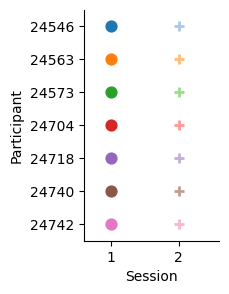

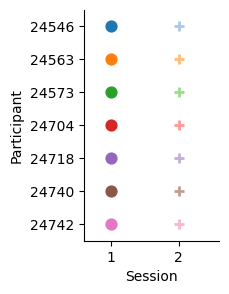

In [70]:
for_key = targcomp.groupby('subject_session')[['subject', 'session']].first().reset_index()
for_key = for_key.rename(columns={'subject':'Participant', 'session':'Session'})
fig, ax = plt.subplots(1, figsize=(1.75,3))
g = sns.pointplot(
    data=for_key,
    y='Participant',
    x='Session',
    hue='subject_session',
    ax=ax,
    markers=markers
)
ax.get_legend().remove()
ax.set_xlim([0.6, 2.6])
ax.set_xticks([1,2])
sns.despine(ax=ax)

/gpfs/gsfs10/users/MLDSST/nielsond/target_test/env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs/gsfs10/users/MLDSST/nielsond/target_test/env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs/gsfs10/users/MLDSST/nielsond/target_test/env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs/gsfs10/users/MLDSST/nielsond/target_test/env/lib/python3.9/site-packages/seaborn/categorical.py:1728: UserWarning: You

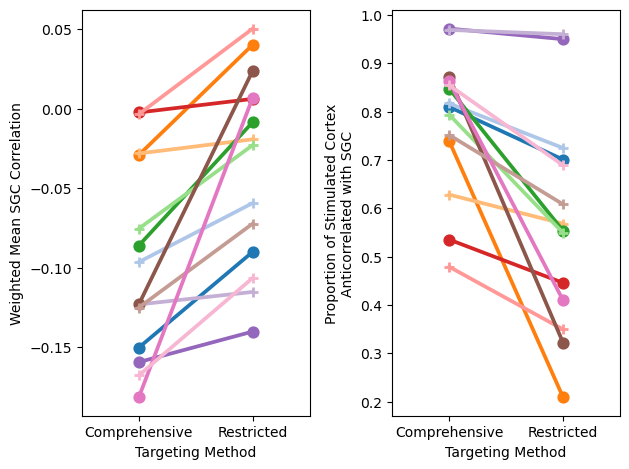

In [71]:
fig, axes = plt.subplots(1,2)
ax = axes[0]
g = sns.pointplot(
    data=targcomp,
    x='Targeting Method',
    y='Weighted Mean SGC Correlation',
    hue='subject_session',
    hue_order=for_key.subject_session,
    ax=ax,
    markers=markers
)
ax.get_legend().remove()
ax = axes[1]
g = sns.pointplot(
    data=targcomp,
    x='Targeting Method',
    y='Proportion of Stimulated Cortex\nAnticorrelated with SGC',
    hue='subject_session',
    hue_order=for_key.subject_session,
    ax=ax,
    markers=markers
)
ax.get_legend().remove()
fig.tight_layout()

# Compare reproducibility

In [72]:
same_targ = targcomp.groupby(['method', 'subject']).pos_ix.nunique().reset_index()
same_targ['same_targ'] = same_targ.pos_ix == 1
same_targ.groupby('method').same_targ.mean()

method
Comprehensive    0.571429
Restricted       0.000000
Name: same_targ, dtype: float64

In [73]:
same_targ

,method,subject,pos_ix,same_targ
0,Comprehensive,24546,1,True
1,Comprehensive,24563,2,False
2,Comprehensive,24573,1,True
3,Comprehensive,24704,2,False
4,Comprehensive,24718,2,False
5,Comprehensive,24740,1,True
6,Comprehensive,24742,1,True
7,Restricted,24546,2,False
8,Restricted,24563,2,False
9,Restricted,24573,2,False


In [74]:
same_targ['scalp_dist'] = 0.
same_targ['ctx_dist'] = 0.
same_targ['mni_ctx_dist'] = 0.

same_targ['stim_corr'] = 1.
same_targ['stim_nz_corr'] = 1.


In [75]:
same_targ

,method,subject,pos_ix,same_targ,scalp_dist,ctx_dist,mni_ctx_dist,stim_corr,stim_nz_corr
0,Comprehensive,24546,1,True,0.0,0.0,0.0,1.0,1.0
1,Comprehensive,24563,2,False,0.0,0.0,0.0,1.0,1.0
2,Comprehensive,24573,1,True,0.0,0.0,0.0,1.0,1.0
3,Comprehensive,24704,2,False,0.0,0.0,0.0,1.0,1.0
4,Comprehensive,24718,2,False,0.0,0.0,0.0,1.0,1.0
5,Comprehensive,24740,1,True,0.0,0.0,0.0,1.0,1.0
6,Comprehensive,24742,1,True,0.0,0.0,0.0,1.0,1.0
7,Restricted,24546,2,False,0.0,0.0,0.0,1.0,1.0
8,Restricted,24563,2,False,0.0,0.0,0.0,1.0,1.0
9,Restricted,24573,2,False,0.0,0.0,0.0,1.0,1.0


In [77]:
ses_comp_cols = [
    'subject',
    'subject_pos',
    'smoothing',
    'pos_ix',
    'weighted_n',
    'area',
    'weighted_area',
    'rep_r_rank',
    'rep_rva_rank',
    'rep_mean',
    'rep_va_mean',
    'rep_std',
    'rep_t',
    'prop_neg',
    'prop_va_neg',
    'in_stim',
    'in_stim_va',
    'bx',
    'by',
    'bz',
    's_x',
    's_y',
    's_z',
    's_idx',
    'z_angle'
]
stim_stats_rev['subject_pos'] = stim_stats_rev.subject + '_' + stim_stats_rev.pos_ix.astype(str)
ss1 = stim_stats_rev.query('session == 1').loc[:, ses_comp_cols] 
ss2 = stim_stats_rev.query('session == 2').loc[:, ses_comp_cols] 
ssw = ss1.merge(ss2, how='inner', on=['subject', 'smoothing'], suffixes=['_1', '_2'])


In [78]:
ss1_winners = ss1.loc[ss1.rep_rva_rank == 1, 'subject_pos'].values
ss2_winners = ss2.loc[ss2.rep_rva_rank == 1, 'subject_pos'].values

In [79]:
s1_on_s2 = ss2.loc[ss2.subject_pos.isin(ss1_winners), ['subject', 'rep_va_mean', 'prop_va_neg', ]]
s1_on_s2['session'] = 2
s2_on_s1 = ss1.loc[ss1.subject_pos.isin(ss2_winners), ['subject', 'rep_va_mean', 'prop_va_neg', ]]
s2_on_s1['session'] = 1
cross_ses = pd.concat([s1_on_s2, s2_on_s1])
cross_ses['method'] = 'Comprehensive'

alt_s1_on_s2 = bgssw.query('smoothing==2.55').loc[bgssw.peak_pos_1 == bgssw.pos_ix_2, ['subject', 'rep_va_mean_2', 'prop_va_neg_2']].groupby('subject').first().reset_index()
alt_s1_on_s2 = alt_s1_on_s2.rename(columns={'rep_va_mean_2':'rep_va_mean', 'prop_va_neg_2': 'prop_va_neg'})
alt_s1_on_s2['session'] = 2
alt_s2_on_s1 = bgssw.query('smoothing==2.55').loc[bgssw.peak_pos_2 == bgssw.pos_ix_1, ['subject', 'rep_va_mean_1', 'prop_va_neg_1']].groupby('subject').first().reset_index()
alt_s2_on_s1 = alt_s2_on_s1.rename(columns={'rep_va_mean_1':'rep_va_mean', 'prop_va_neg_1': 'prop_va_neg'})
alt_s2_on_s1['session'] = 1

alt_cross_ses = pd.concat([ alt_s1_on_s2, alt_s2_on_s1])
alt_cross_ses['method'] = 'Restricted'

cross_ses = pd.concat([cross_ses, alt_cross_ses])

In [80]:
cross_ses['subject_session'] = cross_ses.subject +'_'+cross_ses.session.astype(str)

In [81]:
cross_ses

,subject,rep_va_mean,prop_va_neg,session,method,subject_session
246,24563,-0.011500,0.505798,2,Comprehensive,24563_2
392,24573,-0.075414,0.793742,2,Comprehensive,24573_2
681,24704,-0.000029,0.457038,2,Comprehensive,24704_2
942,24718,-0.119019,0.978046,2,Comprehensive,24718_2
1156,24740,-0.125068,0.751627,2,Comprehensive,24740_2
1447,24742,-0.167757,0.854587,2,Comprehensive,24742_2
1726,24546,-0.096443,0.816855,2,Comprehensive,24546_2
6,24563,-0.026295,0.685431,1,Comprehensive,24563_1
273,24573,-0.086039,0.847446,1,Comprehensive,24573_1
566,24704,0.004571,0.488203,1,Comprehensive,24704_1


In [82]:
cross_ses['Targeting Method'] = cross_ses.method
cross_ses['Weighted Mean SGC Correlation'] = cross_ses.rep_va_mean
cross_ses['Proportion of Stimulated Cortex\nAnticorrelated with SGC'] = cross_ses.prop_va_neg

/gpfs/gsfs10/users/MLDSST/nielsond/target_test/env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs/gsfs10/users/MLDSST/nielsond/target_test/env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs/gsfs10/users/MLDSST/nielsond/target_test/env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs/gsfs10/users/MLDSST/nielsond/target_test/env/lib/python3.9/site-packages/seaborn/categorical.py:1728: UserWarning: You

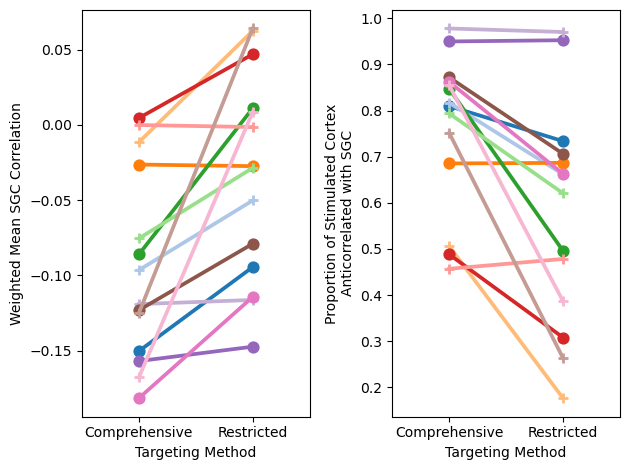

In [83]:
fig, axes = plt.subplots(1,2)
ax = axes[0]
g = sns.pointplot(
    data=cross_ses,
    x='Targeting Method',
    y='Weighted Mean SGC Correlation',
    hue='subject_session',
    hue_order =for_key.subject_session,
    ax=ax,
    markers=markers
)
ax.get_legend().remove()
ax = axes[1]
g = sns.pointplot(
    data=cross_ses,
    x='Targeting Method',
    y='Proportion of Stimulated Cortex\nAnticorrelated with SGC',
    hue='subject_session',
    hue_order =for_key.subject_session,
    ax=ax,
    markers=markers
)
ax.get_legend().remove()
fig.tight_layout()

In [84]:
rep_md = smf.mixedlm('rep_va_mean ~ method', cross_ses, groups=cross_ses["subject"])
rep_mdf = rep_md.fit(method=["lbfgs"])
print(rep_mdf.summary())

             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   rep_va_mean
No. Observations:   28        Method:               REML       
No. Groups:         7         Scale:                0.0020     
Min. group size:    4         Log-Likelihood:       35.7604    
Max. group size:    4         Converged:            Yes        
Mean group size:    4.0                                        
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.094    0.023 -4.115 0.000 -0.139 -0.049
method[T.Restricted]  0.061    0.017  3.593 0.000  0.028  0.094
Group Var             0.003    0.046                           



/gpfs/gsfs10/users/MLDSST/nielsond/target_test/env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [85]:
rep_mdf.pvalues

Intercept               0.000039
method[T.Restricted]    0.000327
Group Var               0.201159
dtype: float64

In [86]:
rep_md = smf.mixedlm('prop_va_neg ~ method', cross_ses, groups=cross_ses["subject"])
rep_mdf = rep_md.fit(method=["lbfgs"])
print(rep_mdf.summary())

             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   prop_va_neg
No. Observations:   28        Method:               REML       
No. Groups:         7         Scale:                0.0208     
Min. group size:    4         Log-Likelihood:       5.6576     
Max. group size:    4         Converged:            Yes        
Mean group size:    4.0                                        
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.762    0.070 10.881 0.000  0.625  0.900
method[T.Restricted] -0.184    0.054 -3.370 0.001 -0.290 -0.077
Group Var             0.024    0.133                           



In [87]:
rep_mdf.pvalues

Intercept               1.422022e-27
method[T.Restricted]    7.526951e-04
Group Var               2.117418e-01
dtype: float64

In [88]:
alt_cross_ses

,subject,rep_va_mean,prop_va_neg,session,method
0,24546,-0.050162,0.661797,2,Restricted
1,24563,0.062506,0.176322,2,Restricted
2,24573,-0.028543,0.620658,2,Restricted
3,24704,-0.001387,0.478354,2,Restricted
4,24718,-0.116245,0.970423,2,Restricted
5,24740,0.064087,0.263248,2,Restricted
6,24742,0.008546,0.386642,2,Restricted
0,24546,-0.094415,0.733731,1,Restricted
1,24563,-0.027366,0.686706,1,Restricted
2,24573,0.011089,0.495783,1,Restricted


In [89]:
def get_mni_dist(row):
    subject = row.subject
    mni_surf_dir = liston_root / f'sub-{subject}/anat/MNINonLinear/fsaverage_LR32k/'
    l_surf_path = mni_surf_dir / f'sub-{subject}.L.midthickness.32k_fs_LR.surf.gii'
    points, triangles = nb.load(l_surf_path).agg_data()
    return cdist([points[int(row.s_idx_1)]],[points[int(row.s_idx_2)]])[0][0] 

In [90]:
diff_idx = (
    (ssw.pos_ix_1 != ssw.pos_ix_2)
    & ((ssw.rep_rva_rank_1 == 1) & (ssw.rep_rva_rank_2 == 1))
)
diff_dat = ssw.loc[diff_idx].copy()
diff_dat['method'] = 'Comprehensive'
alt_diff_dat = bgssw.loc[(bgssw.pos_ix_1 != bgssw.pos_ix_2) & (bgssw.peak_pos_1 != bgssw.peak_pos_2)].groupby('subject').first().reset_index()
alt_diff_dat['method'] = 'Restricted'
diff_dat = pd.concat([diff_dat, alt_diff_dat]).reset_index(drop=True)

In [91]:
diff_dat.loc[:, ['subject', 'pos_ix_1', 'pos_ix_2', 'rep_rva_rank_1', 'rep_rva_rank_2', 'peak_pos_1', 'peak_pos_2']]

,subject,pos_ix_1,pos_ix_2,rep_rva_rank_1,rep_rva_rank_2,peak_pos_1,peak_pos_2
0,24563,110,6,1.0,1.0,NaN,NaN
1,24704,58,56,1.0,1.0,NaN,NaN
2,24718,75,33,1.0,1.0,NaN,NaN
3,24546,0,1,NaN,NaN,1.0,0.0
4,24563,0,1,NaN,NaN,0.0,1.0
5,24573,0,1,NaN,NaN,0.0,1.0
6,24704,0,1,NaN,NaN,0.0,1.0
7,24718,0,1,NaN,NaN,1.0,0.0
8,24740,0,1,NaN,NaN,0.0,1.0
9,24742,0,1,NaN,NaN,1.0,0.0


In [95]:
scalp_loc_1 = diff_dat.loc[:, ['bx_1', 'by_1', 'bz_1']].values
scalp_loc_2 = diff_dat.loc[:, ['bx_2', 'by_2', 'bz_2']].values
ctx_loc_1 = diff_dat.loc[:, ['s_x_1', 's_y_1', 's_z_1']].values
ctx_loc_2 = diff_dat.loc[:, ['s_x_2', 's_y_2', 's_z_2']].values
scalp_dist = []
for sl1, sl2 in zip(scalp_loc_1, scalp_loc_2):
    scalp_dist.append(cdist([sl1], [sl2])[0][0])
    
ctx_dist = []
for sl1, sl2 in zip(ctx_loc_1, ctx_loc_2):
    ctx_dist.append(cdist([sl1], [sl2])[0][0])


In [96]:
mni_ctx_dist = diff_dat.reset_index().apply(get_mni_dist, axis=1).values

In [97]:
same_targ.loc[~same_targ.same_targ, 'scalp_dist'] = scalp_dist
same_targ.loc[~same_targ.same_targ, 'ctx_dist'] = ctx_dist
same_targ.loc[~same_targ.same_targ, 'mni_ctx_dist'] = mni_ctx_dist


In [98]:
same_targ

,method,subject,pos_ix,same_targ,scalp_dist,ctx_dist,mni_ctx_dist,stim_corr,stim_nz_corr
0,Comprehensive,24546,1,True,0.000000,0.000000,0.000000,1.0,1.0
1,Comprehensive,24563,2,False,28.882688,22.791379,25.526391,1.0,1.0
2,Comprehensive,24573,1,True,0.000000,0.000000,0.000000,1.0,1.0
3,Comprehensive,24704,2,False,4.962222,7.641910,6.994776,1.0,1.0
4,Comprehensive,24718,2,False,13.310654,12.451996,22.522542,1.0,1.0
5,Comprehensive,24740,1,True,0.000000,0.000000,0.000000,1.0,1.0
6,Comprehensive,24742,1,True,0.000000,0.000000,0.000000,1.0,1.0
7,Restricted,24546,2,False,16.869557,17.703144,18.326393,1.0,1.0
8,Restricted,24563,2,False,33.849197,4.473310,6.045768,1.0,1.0
9,Restricted,24573,2,False,30.379266,6.897675,8.786057,1.0,1.0


In [99]:
stim_corrs = []
stim_nz_corrs = []
for subject,row in diff_dat.iterrows():
    subject=row.subject
    src_surf_dir = liston_root / f'sub-{subject}/anat/T1w/fsaverage_LR32k/'
    sim_out_dir = anat_dir / f'sub-{subject}/Simulation'
    if row.method == 'Restrictive':
        sim_dir = sorted(sim_out_dir.glob('alternate_targeting-*'))[-1]
    else:
        sim_dir = sorted(sim_out_dir.glob('simulation-*'))[-1]

    uncert_dir = sim_dir / f'uncert{uncert_n}'
    #load prob map
    ap_path = uncert_dir / f'sub-{subject}_space-fsLR_den-32k_desc-abovethreshactprobs_stat.dtseries.nii'
    ap_img = ci.load(ap_path)
    all_ap = ap_img.get_fdata()
    l_ap = surf_data_from_cifti(all_ap, ap_img.header.get_axis(1), 'CIFTI_STRUCTURE_CORTEX_LEFT')
    all_ap = all_ap.T

    # load va map
    va_path = src_surf_dir / f'sub-{subject}.midthickness_va.32k_fs_LR.dscalar.nii'
    va_img = ci.load(va_path)
    all_va = va_img.get_fdata()
    l_va = surf_data_from_cifti(all_va, va_img.header.get_axis(1), 'CIFTI_STRUCTURE_CORTEX_LEFT')
    
    flat_ap_1 = l_ap[:, int(row.pos_ix_1)]
    flat_ap_2 = l_ap[:, int(row.pos_ix_2)]
    flat_ap_nz_idx = (flat_ap_1 != 0) | (flat_ap_1 != 0)
    
    stim_corrs.append(np.corrcoef(flat_ap_1, flat_ap_2)[1,0])
    stim_nz_corrs.append(np.corrcoef(flat_ap_1[flat_ap_nz_idx], flat_ap_2[flat_ap_nz_idx])[1,0])

In [100]:
same_targ.loc[~same_targ.same_targ, 'stim_corr'] = stim_corrs
same_targ.loc[~same_targ.same_targ, 'stim_nz_corr'] = stim_nz_corrs

In [101]:
same_targ = same_targ.merge(inter_subject_dist.groupby('method').isdist.mean().reset_index(),how='left',on='method')

In [102]:
same_targ['inter_intra_ratio'] = same_targ.isdist / same_targ.mni_ctx_dist

In [103]:
same_targ

,method,subject,pos_ix,same_targ,scalp_dist,ctx_dist,mni_ctx_dist,stim_corr,stim_nz_corr,isdist,inter_intra_ratio
0,Comprehensive,24546,1,True,0.000000,0.000000,0.000000,1.000000,1.000000,19.714868,inf
1,Comprehensive,24563,2,False,28.882688,22.791379,25.526391,0.479389,0.312475,19.714868,0.772333
2,Comprehensive,24573,1,True,0.000000,0.000000,0.000000,1.000000,1.000000,19.714868,inf
3,Comprehensive,24704,2,False,4.962222,7.641910,6.994776,0.967635,0.955089,19.714868,2.818513
4,Comprehensive,24718,2,False,13.310654,12.451996,22.522542,0.651483,0.588168,19.714868,0.875339
5,Comprehensive,24740,1,True,0.000000,0.000000,0.000000,1.000000,1.000000,19.714868,inf
6,Comprehensive,24742,1,True,0.000000,0.000000,0.000000,1.000000,1.000000,19.714868,inf
7,Restricted,24546,2,False,16.869557,17.703144,18.326393,0.817970,0.754811,16.842432,0.919026
8,Restricted,24563,2,False,33.849197,4.473310,6.045768,0.539524,0.426397,16.842432,2.785822
9,Restricted,24573,2,False,30.379266,6.897675,8.786057,0.161799,0.154425,16.842432,1.916950


In [104]:
same_targ_comp = same_targ.loc[same_targ.method == 'Comprehensive', ['subject',  'scalp_dist','ctx_dist', 'mni_ctx_dist', 'inter_intra_ratio', 'stim_corr']]
same_targ_2s = same_targ.loc[same_targ.method == 'Restricted', ['subject',  'scalp_dist', 'ctx_dist', 'mni_ctx_dist', 'inter_intra_ratio', 'stim_corr']]


In [105]:
display_rename = {'subject': 'Participant ID', 'same_targ':'Same Target?', 'scalp_dist':'Intersession Scalp Distance',
                  'mni_ctx_dist': 'Intersession Cortical Distance', 'isdist':'Intersubject Cortical Distance',
                  'inter_intra_ratio': 'Intersubject-Intrasubject Ratio', 'stim_corr': 'Intersession Correlation of Activation Probability'} 
same_targ_comp.rename(columns=display_rename)

,Participant ID,Intersession Scalp Distance,ctx_dist,Intersession Cortical Distance,Intersubject-Intrasubject Ratio,Intersession Correlation of Activation Probability
0,24546,0.000000,0.000000,0.000000,inf,1.000000
1,24563,28.882688,22.791379,25.526391,0.772333,0.479389
2,24573,0.000000,0.000000,0.000000,inf,1.000000
3,24704,4.962222,7.641910,6.994776,2.818513,0.967635
4,24718,13.310654,12.451996,22.522542,0.875339,0.651483
5,24740,0.000000,0.000000,0.000000,inf,1.000000
6,24742,0.000000,0.000000,0.000000,inf,1.000000


In [106]:
same_targ_2s.rename(columns=display_rename)

,Participant ID,Intersession Scalp Distance,ctx_dist,Intersession Cortical Distance,Intersubject-Intrasubject Ratio,Intersession Correlation of Activation Probability
7,24546,16.869557,17.703144,18.326393,0.919026,0.817970
8,24563,33.849197,4.473310,6.045768,2.785822,0.539524
9,24573,30.379266,6.897675,8.786057,1.916950,0.161799
10,24704,18.338383,1.698641,1.652502,10.192080,0.938994
11,24718,8.787865,15.585156,20.816949,0.809073,0.258758
12,24740,5.354445,6.272632,6.623625,2.542782,0.887251
13,24742,18.615128,4.485762,4.754424,3.542476,0.995672
